In [1]:
import os
import os.path
#import tensorflow as tf
import numpy as np
from keras import layers
from keras import utils
from keras import regularizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.utils import plot_model
import random
print(os.path)

Using TensorFlow backend.


<module 'ntpath' from 'D:\\ProgramData\\Anaconda3\\lib\\ntpath.py'>


In [2]:
Time=4
Fs=750
dir_path =((r"J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912"))#这里的路径是打包文件里数据中训练数据文件夹的路径#
filename = []
sigNames = []
sigfileCount = dict()
i=0
Na=0
pa=0
n_event_kinds=0
siglist = []
#get the signal types from directory
for parent, dirnames, filenames in os.walk(dir_path):  # 三个参数：分别返回1.父目录 2.所有文件夹名字（不含路径） 3.所有文件名字
    for dirname in dirnames:  # 输出文件夹信息
        #print("parent is:" + parent)
        #print("dirname is" + dirname)
        sigNames.append(dirname)
        sigfileCount[sigNames[n_event_kinds]]=0
        n_event_kinds += 1
    for filename in filenames:  # 输出文件信息
        #print( "parent is:" + parent)
        if len(parent) <= len(dir_path):
            continue
        i = sigNames.index(parent[-2:])
        sigfileCount[sigNames[i]] += 1
        #print("filename is:" + filename)
        #print( "the full name of the file is:" + os.path.join(parent, filename)) # 输出文件路径信息
print(n_event_kinds)
        
i=0
j=0
Nf=np.zeros(10) #Nf=np.ones((1,100),dtype=int)
siglist = []
for sigtype in sigNames:
    ifr = np.random.rand
    typepath = os.path.join(dir_path, sigtype)
    files = int(sigfileCount[sigNames[i]])
    rfn = np.random.randint(0, files-1, size=(files-1))
    #print(rfn,sigfileCount[sigNames[i]])
    print(typepath)
    j = 0
    f = 0
    break_flag=False
    for parent, dirnames, filenames in os.walk(typepath):
        for filename in filenames:  # 输出文件夹信息
            if j in rfn:
                fullpath = os.path.join(typepath, filename)
                #print(fullpath)
                fr=open(fullpath,'rb')                                         
                fr.seek(0,2)
                pf=fr.tell()
                sigcount=int(pf/Time/Fs/4)
                Nf[i]+=sigcount
                print(Nf[i])
                fr.seek(0,0)
                signal=np.fromfile(fr,dtype=">f4",count=-1)
                sig=np.reshape(signal[:int(sigcount)*Time*Fs],(int(sigcount),Time*Fs)) 
                if f==0:
                    dlst=sig
                else:
                    clst=sig
                    dlst=np.r_[dlst,clst]
                fr.close()
                f += 1
                if Nf[i]>6000:
                    break_flag=True
                    break
            j += 1
            if break_flag==True:
                break;
        if break_flag==True:
            break;
    sigfileCount[sigNames[i]]=Nf[i]  # files count dict to signals count dict
    siglist.append(dlst)
    print (dlst.shape)
    print ("事件段数：%d"% (Nf[i]))
    Na += Nf[i]
    pa += pf;
    i += 1
print ("全部事件的位置: %d" % (pa))
print ("全部事件的段数：%d"% (Na))

7
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\人工
918.0
1899.0
3118.0
4337.0
5650.0
6997.0
(6997, 3000)
事件段数：6997
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\噪声
6315.0
(6315, 3000)
事件段数：6315
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\回填
1455.0
2910.0
5277.0
7644.0
(7644, 3000)
事件段数：7644
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\怠机
3075.0
8046.0
(8046, 3000)
事件段数：8046
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\挖掘
2747.0
5822.0
9194.0
(9194, 3000)
事件段数：9194
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\电镐
1640.0
3280.0
4920.0
6560.0
(6560, 3000)
事件段数：6560
J:\\Companys\\邢冀川\\光纤线号分析\\数据20190912\行驶
1476.0
4233.0
6990.0
(6990, 3000)
事件段数：6990
全部事件的位置: 273261000
全部事件的段数：51746


In [5]:
lmax=np.max(Nf)
print('max:',lmax)
Mf=Nf.copy()
Mf[Nf<1]=lmax
lmin=np.min(Mf) #get the least number
print('min:',lmin)
#数据标签
y_label=np.zeros((int(lmin*n_event_kinds),n_event_kinds),np.uint16)    
print(y_label.shape)
#one_hot_train_labels = to_categorical(train_labels)
for i in np.arange(n_event_kinds):
    if i==0:
        dlst=siglist[0][:int(lmin),:]
    else:
        clst=siglist[i][:int(lmin),:]
        dlst=np.r_[dlst,clst]
    y_label[int(i*lmin):int((i+1)*lmin), i:i+1] = 1
    print(y_label[int(i*lmin)])
allsig=dlst        
ttSamples = allsig.shape[0]
print('samples count:', ttSamples)

#shuffle data and labels
idxrand = np.arange(allsig.shape[0])
np.random.shuffle(idxrand)
data = allsig[idxrand]
labels = y_label[idxrand]

#plt.plot(sig[500,:])
sdmean = np.mean(data, axis=0)
sdsigma = np.std(data, axis=0)
print('mean:',sdmean)
print('sigma',sdsigma)
normalized_data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
#plt.plot(normalized_data[500,:])
numTr = int(ttSamples*0.9)
train_data = normalized_data[0:numTr,:]
train_label = labels[0:numTr,:]
test_data = normalized_data[numTr:,:]
test_label = labels[numTr:,:]

train_data = np.expand_dims(train_data, axis=2) #表示是是增加的维度是在第三个维度上
test_data = np.expand_dims(test_data, axis=2) #表示是是增加的维度是在第三个维度上

max: 9194.0
min: 6315.0
(44205, 7)
[1 0 0 0 0 0 0]
[0 1 0 0 0 0 0]
[0 0 1 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 0 1 0 0]
[0 0 0 0 0 1 0]
[0 0 0 0 0 0 1]
samples count: 44205
mean: [4438.2837 4435.8823 4438.711  ... 4436.3916 4437.078  4439.1733]
sigma [1069.445  1068.5322 1070.58   ... 1069.1239 1068.8511 1070.4144]








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2996, 128)         768       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 998, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 994, 64)           41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 331, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 327, 32)           10272     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Tota

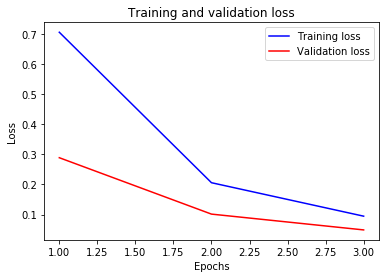

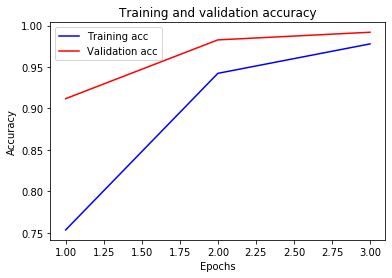

4421/4421 [==============================] - 2s 469us/step
test_acc: 0.9895951142275503
orginal data test_acc: 0.9895951142275503
['人工', '噪声', '回填', '怠机', '挖掘', '电镐', '行驶']


In [6]:
#stack layers
max_features = Time * Fs
model = Sequential()
model.add(layers.Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.001), activation='relu',input_shape=(max_features,1)))
model.add(layers.MaxPooling1D(3))
#model.add(Dropout(0.5))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(n_event_kinds, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True, to_file='fiber_model5.png')

#begin training and get loss
history = model.fit(train_data, train_label, epochs=3, batch_size=128, validation_split=0.3)
model.save('fiber.h5') #save training results

loss = history.history['loss']
val_loss = history.history['val_loss']
#print('val loss', val_loss)
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy of training
acc = history.history['acc']
val_acc = history.history['val_acc']
#print('val acc', val_acc)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_label)
print('test_acc:', test_acc)
pred_score = model.predict(test_data)
sigpre = pred_score.argmax(1)
sigtst = test_label.argmax(1)
d=(sigpre==sigtst)
dt=sum(d==True)
per=dt/test_data.shape[0]
print('orginal data test_acc:', per) #precent result of right predicted
print(sigNames)

测试数据：3142
测试数据：4024
测试数据：3986
(11152,)
[3142, 7166, 11152, 11316]
[1 6]
[6 2]
[2]
[]
(11152, 7)
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]
11152 11152
11152/11152 [==============================] - 28s 2ms/step
genaralized test_acc: 0.02098278335724534


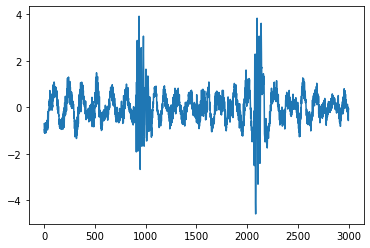

In [10]:
#22222222222222222222222222222222222222读出另外一组测试数据
#another group of data
Time=4
Fs=750
dir_path =((r"J:\dataset\fiber"))#这里的路径是打包文件里数据中训练数据文件夹的路径#
filename = ['\\1rengong.dat', '\\2diangao_jixie.dat', '\\3noise.dat', '\\4.wajiwanjue.dat']
#filename = ['\\1.rengong2.dat', '\\2.diangao2.dat', '\\3.noise2.dat', '\\8.waji_wajue.dat']
Nf=np.ones((1,100),dtype=int)
Nf=np.arange(1,100,1)
i=0
Na=0
pa=0
alltest = np.arange(0).reshape(0, 100)
for fn in filename:
    dfile = dir_path + fn
    fr=open(dfile,'rb')                                         
    fr.seek(0,2)
    pf=fr.tell()
    Nf[i]=int(pf/Time/Fs/4)
    if Nf[i]<1000:
        fr.close
        continue    
    print ("测试数据：%d"% (Nf[i]))
    fr.seek(0,0)
    signal=np.fromfile(fr,dtype=">f4",count=-1)
    sig=np.reshape(signal,(int(Nf[i]),Time*Fs)) 
    if i==0:
        alltest= sig
    else:
        alltest = np.concatenate([alltest,sig])
    fr.close()
    Na += Nf[i]
    pa += pf;
    i += 1
n_event_test = i
    
test_label=np.zeros((int(alltest.shape[0]),),np.uint16)
print(test_label.shape)
Nc = [Nf[0], Nf[0]+Nf[1], Nf[0]+Nf[1]+Nf[2],Nf[0]+Nf[1]+Nf[2]+Nf[3]]
print(Nc)
test_label[0:Nc[0]]=1
test_label[Nc[0]:Nc[1]]=6
test_label[Nc[1]:Nc[2]]=2
test_label[Nc[2]:Nc[3]]=5
print(test_label[Nc[0]-1:Nc[0]+1]),print(test_label[Nc[1]-1:Nc[1]+1]),print(test_label[Nc[2]-1:Nc[2]+1]),print(test_label[Nc[3]-1:Nc[3]+1])
test_label = utils.to_categorical(test_label)
print(test_label.shape)
print(test_label[Nc[0]-2:Nc[0]+2])
test_data = (alltest - np.mean(alltest, axis=0)) / np.std(alltest, axis=0)
plt.plot(test_data[1,:])
test_data = np.expand_dims(test_data, axis=2) 
print(len(test_data), len(test_label))
test_loss, test_acc = model.evaluate(test_data, test_label)
print('genaralized test_acc:', test_acc)

3142


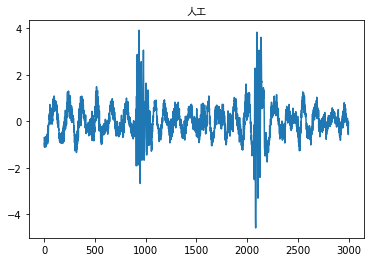

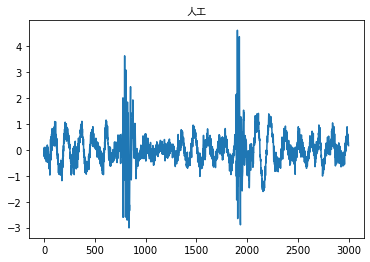

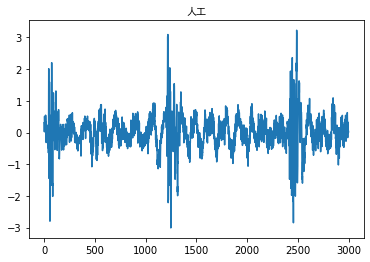

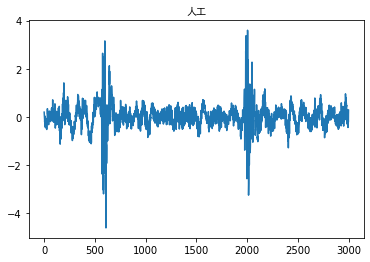

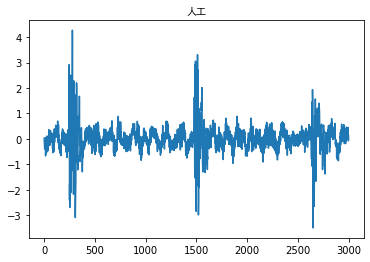

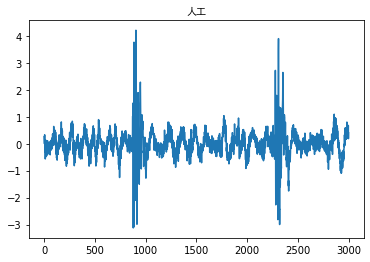

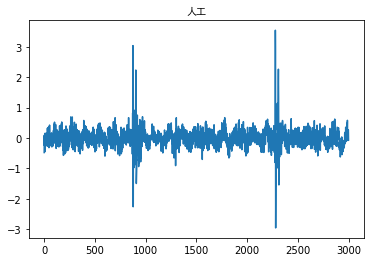

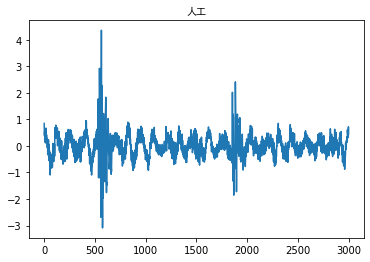

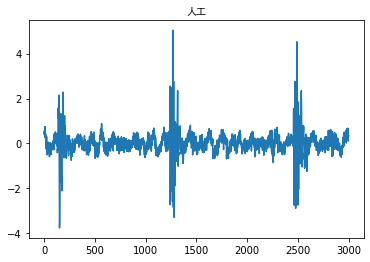

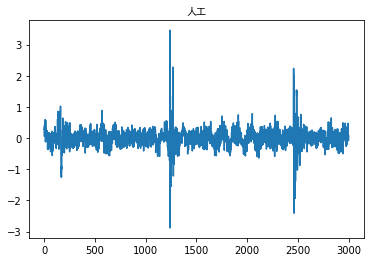

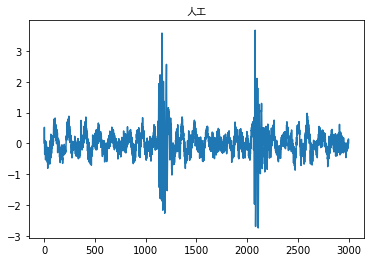

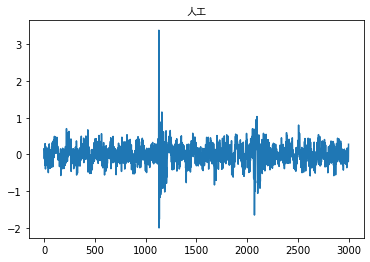

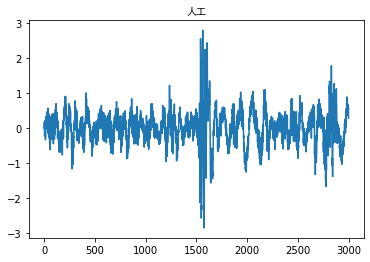

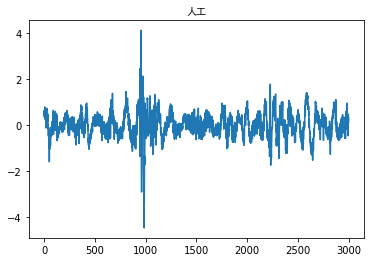

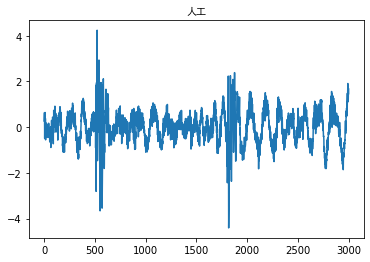

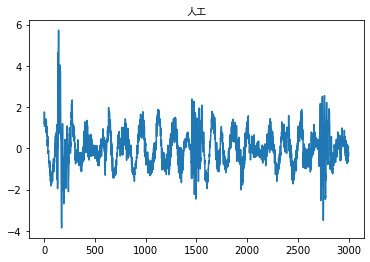

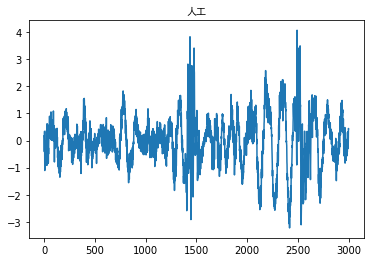

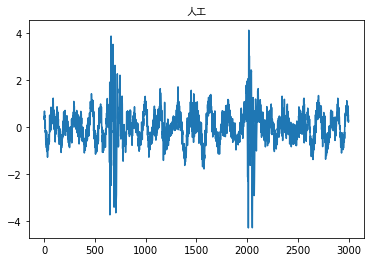

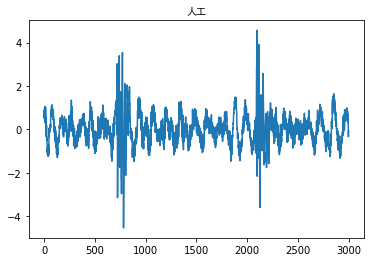

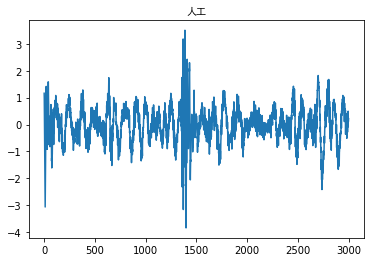

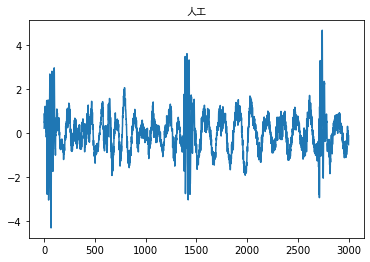

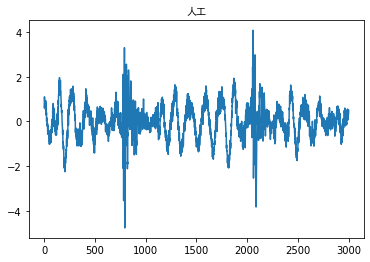

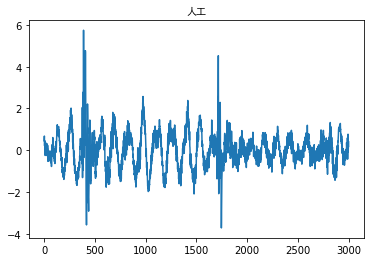

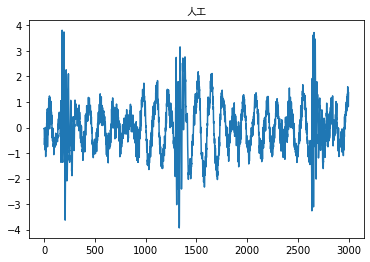

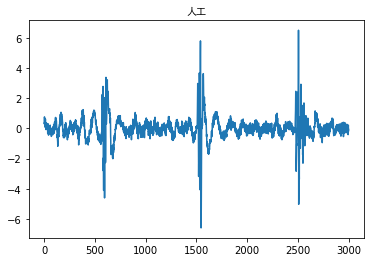

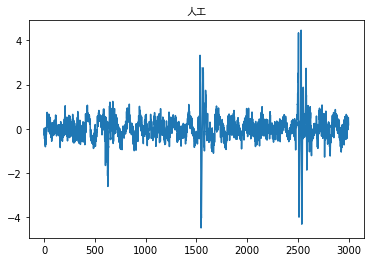

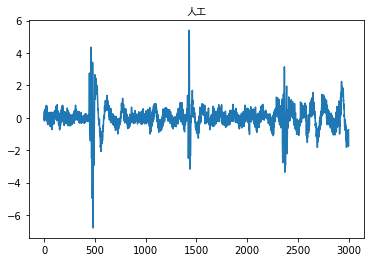

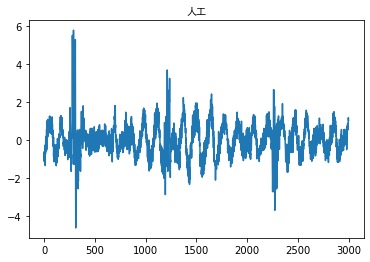

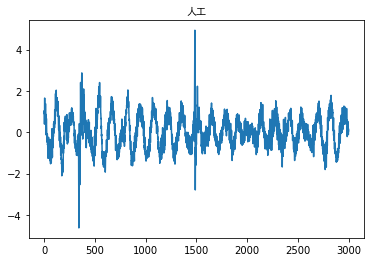

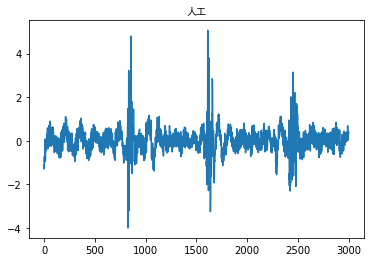

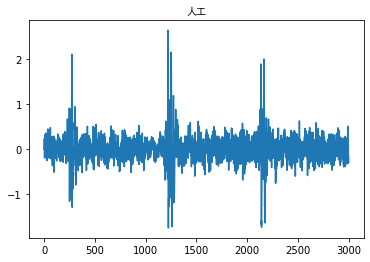

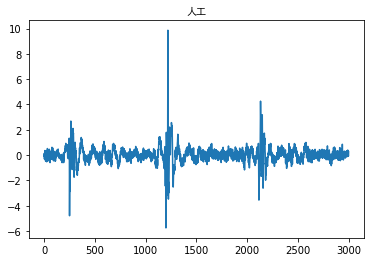

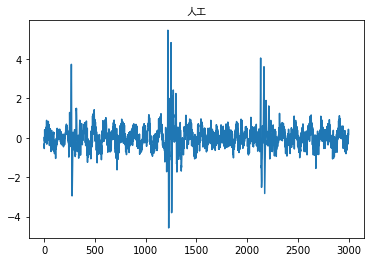

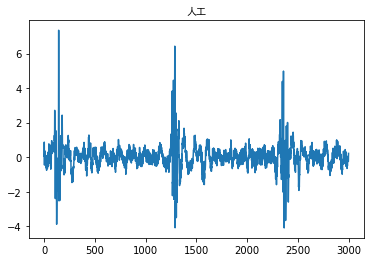

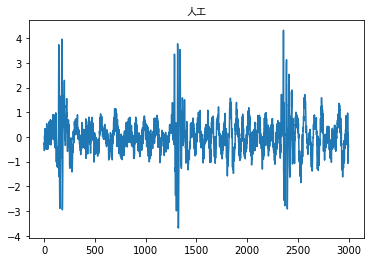

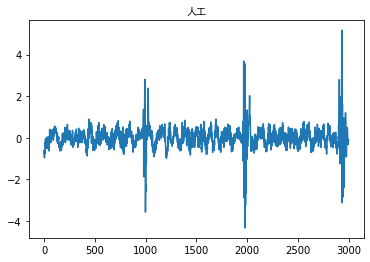

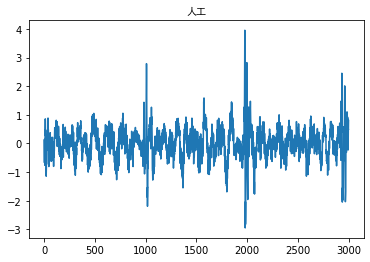

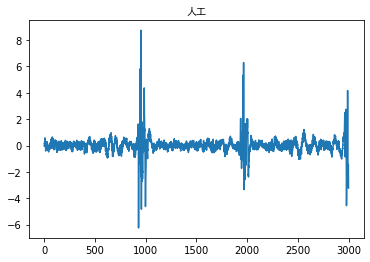

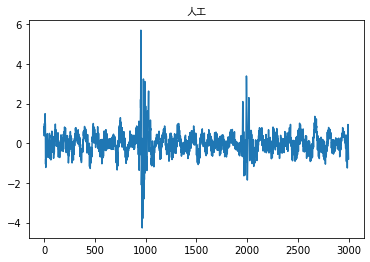

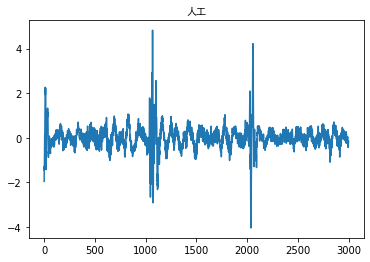

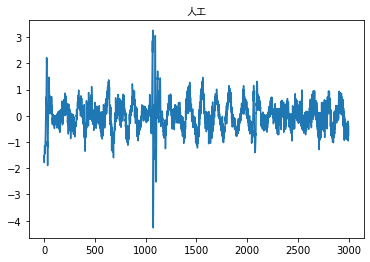

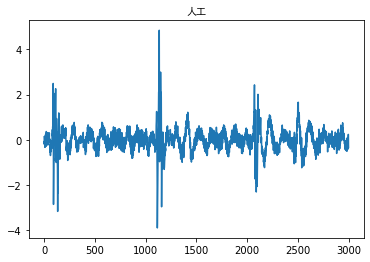

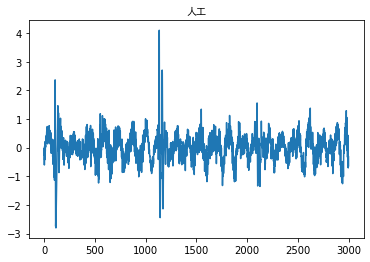

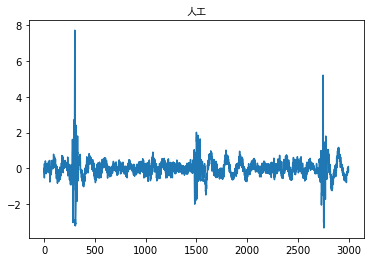

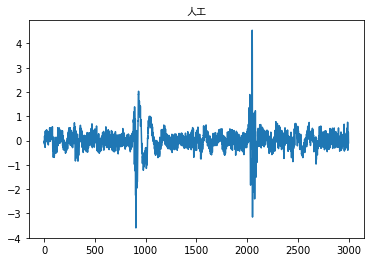

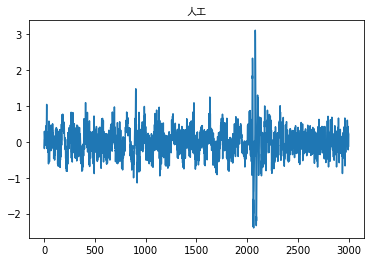

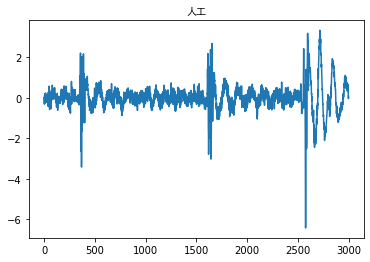

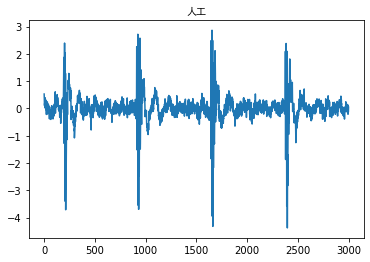

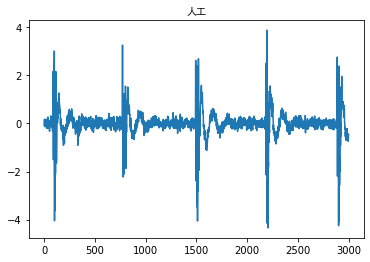

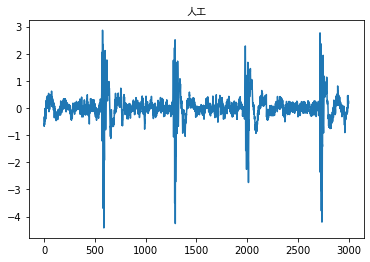

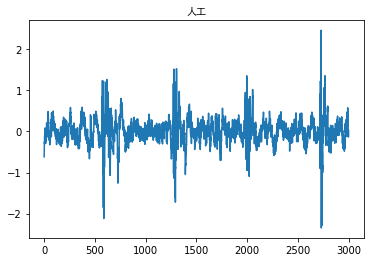

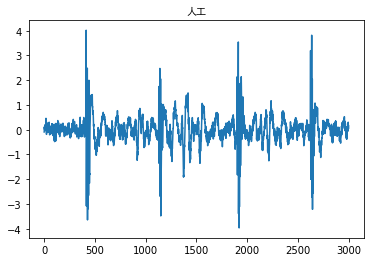

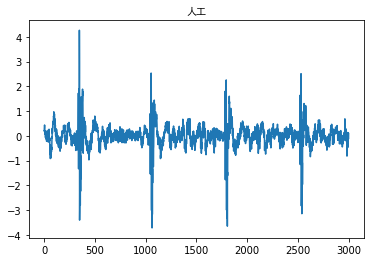

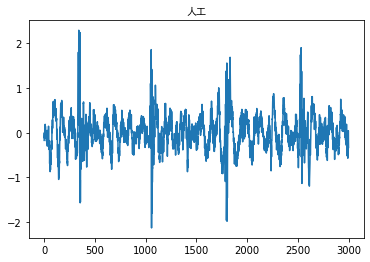

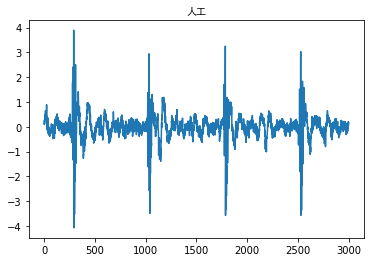

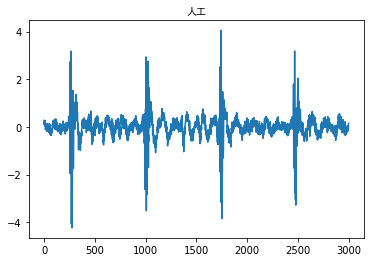

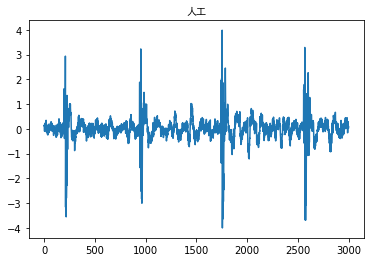

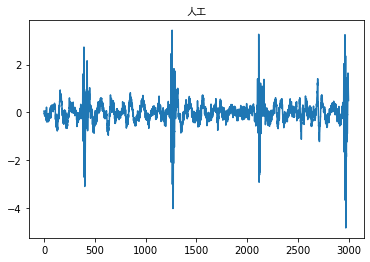

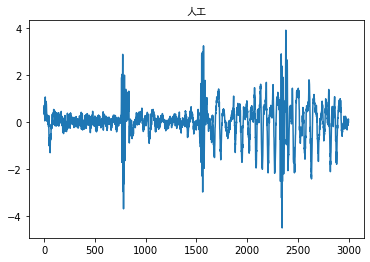

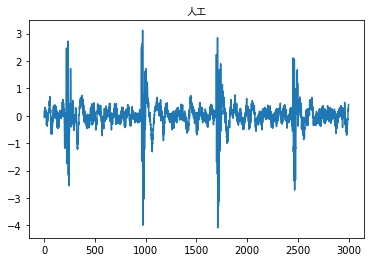

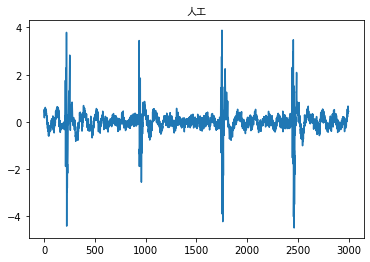

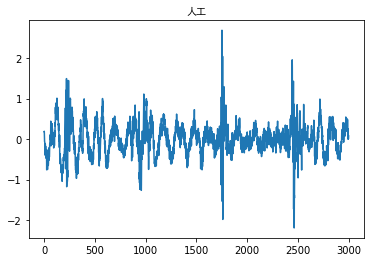

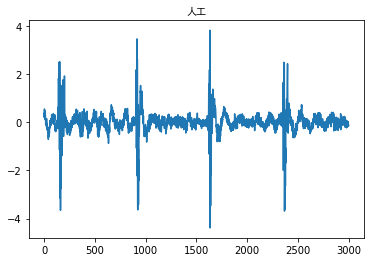

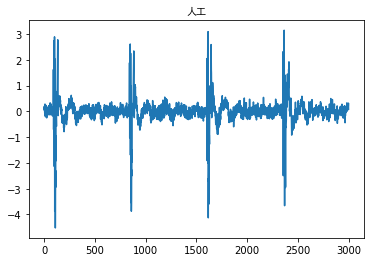

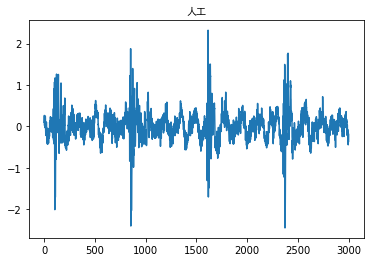

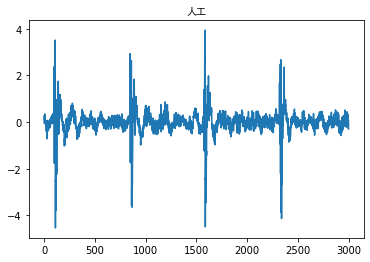

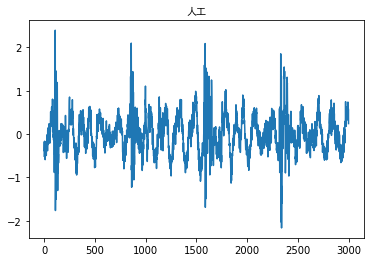

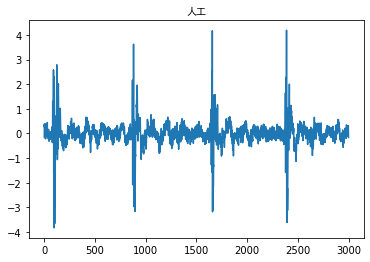

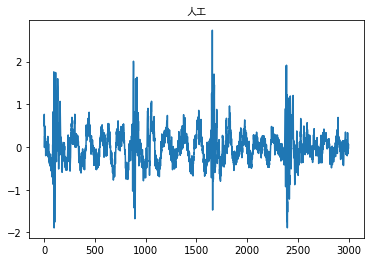

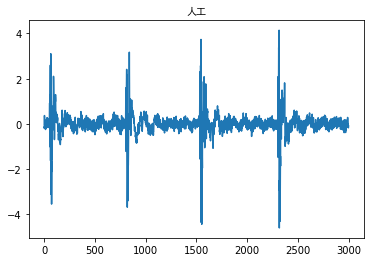

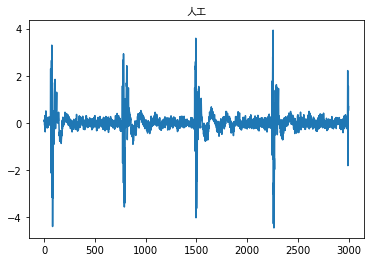

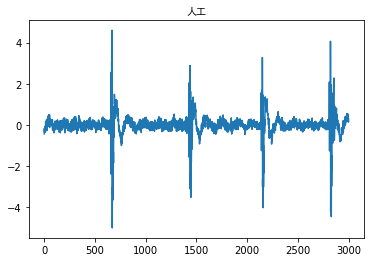

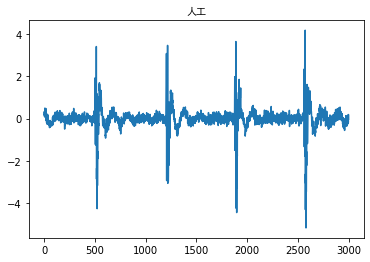

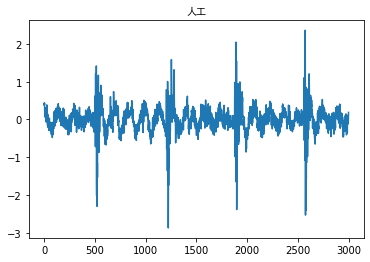

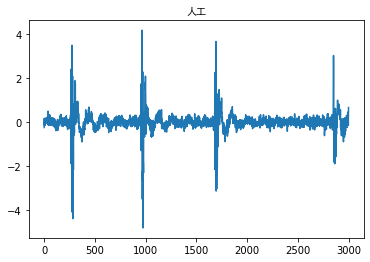

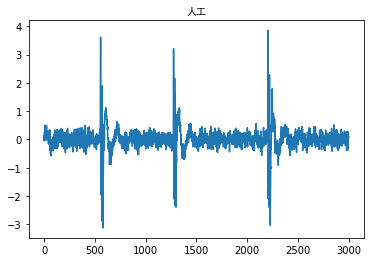

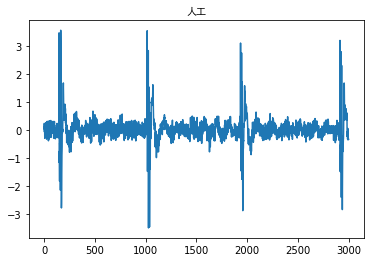

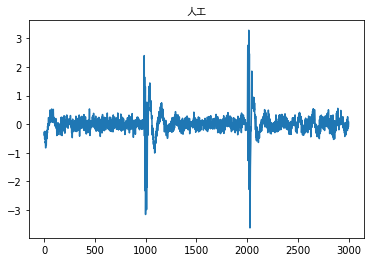

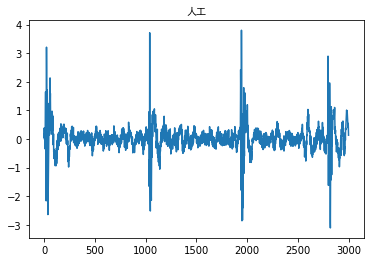

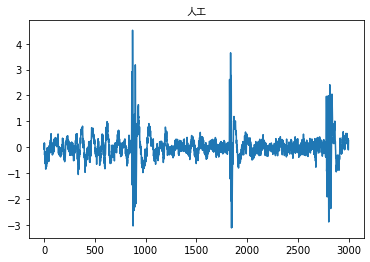

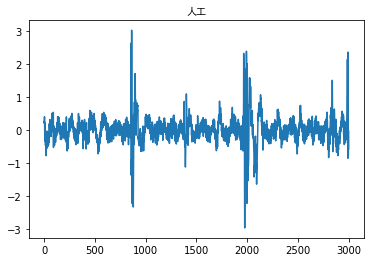

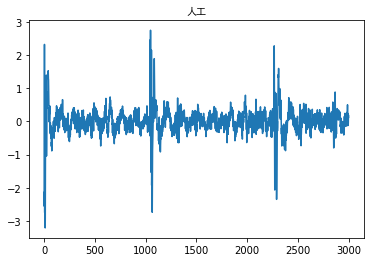

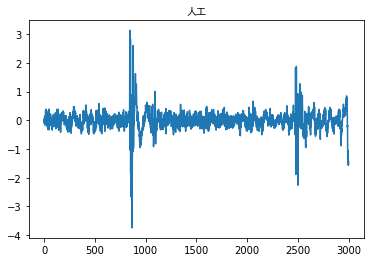

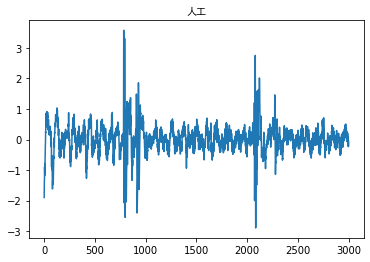

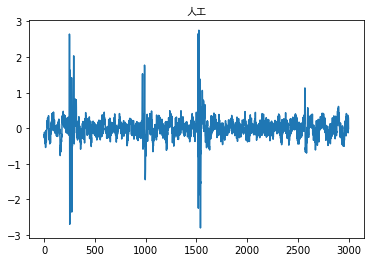

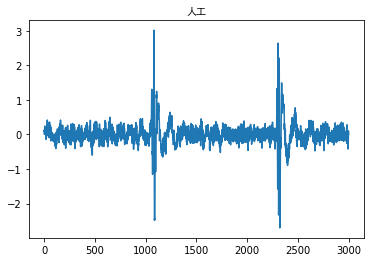

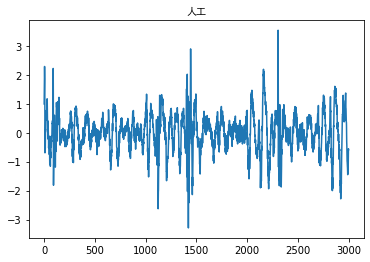

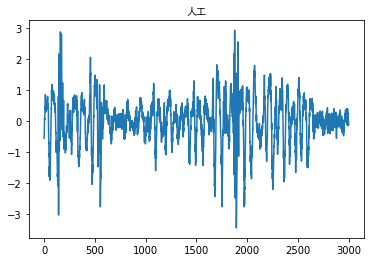

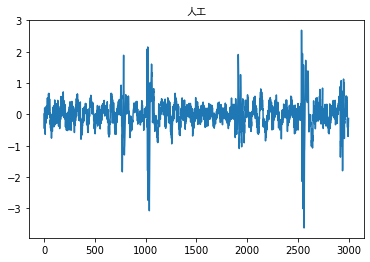

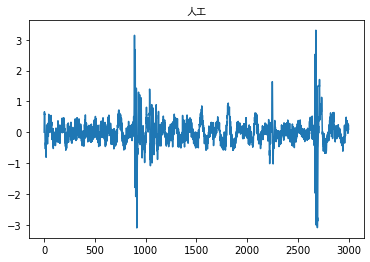

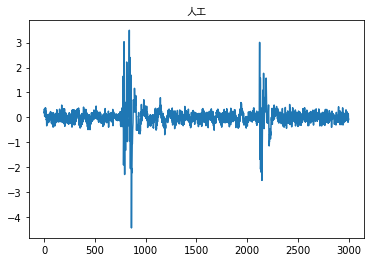

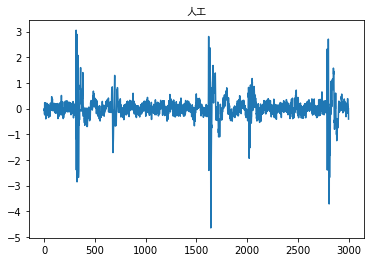

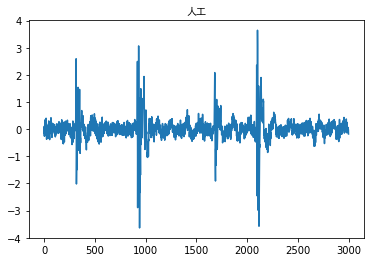

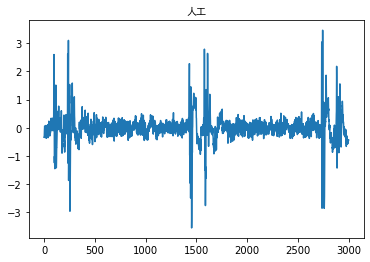

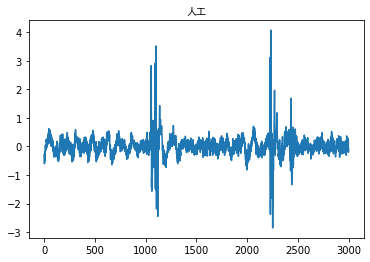

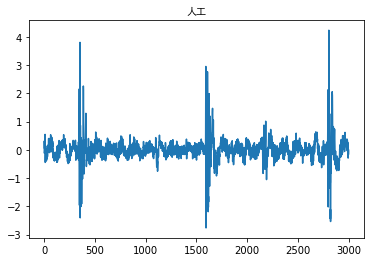

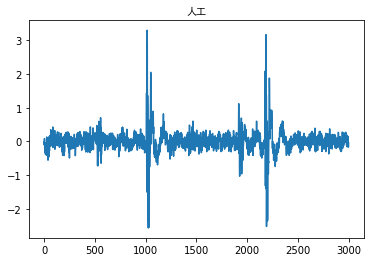

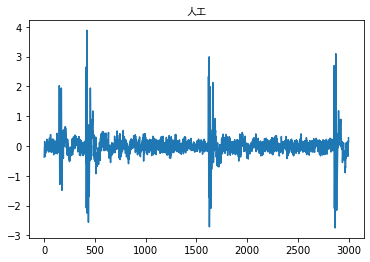

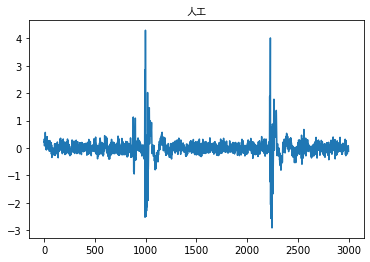

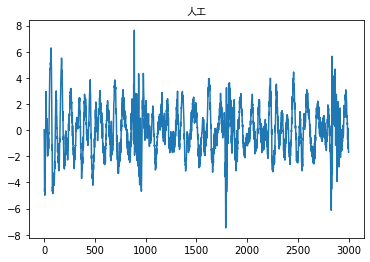

4024


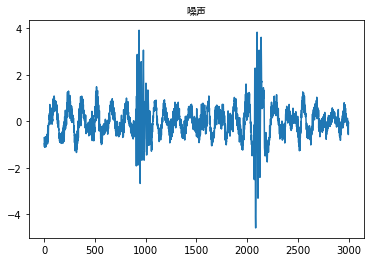

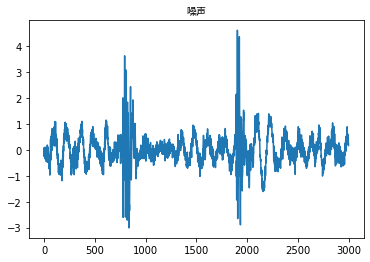

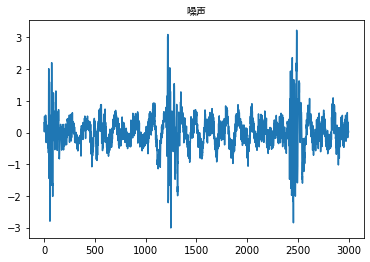

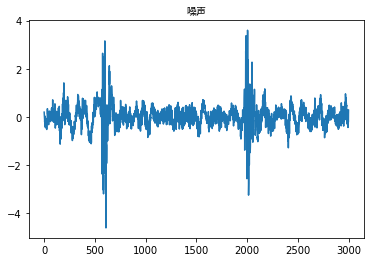

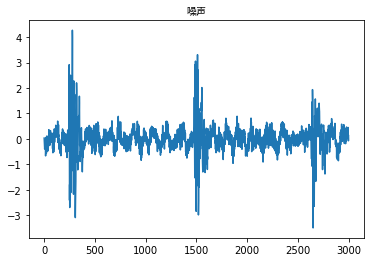

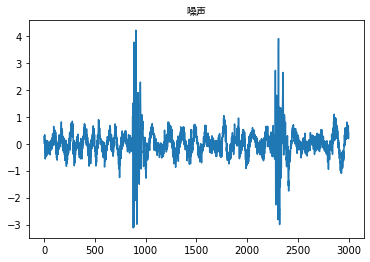

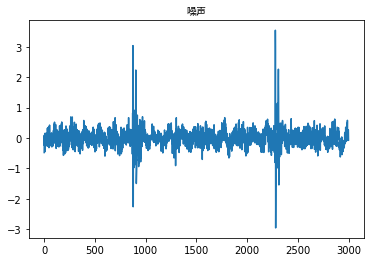

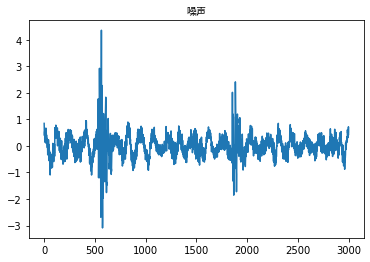

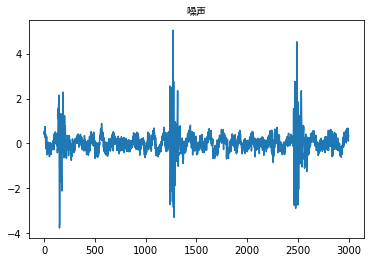

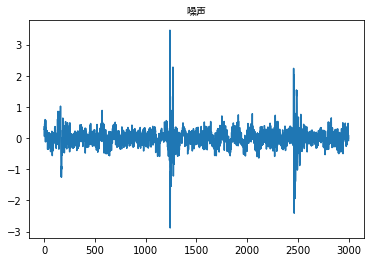

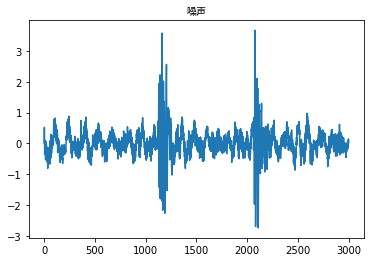

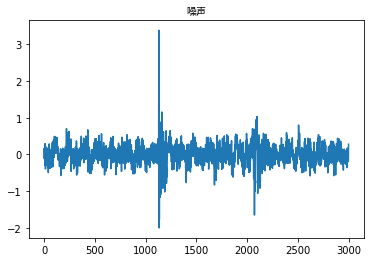

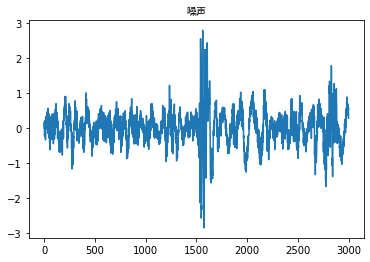

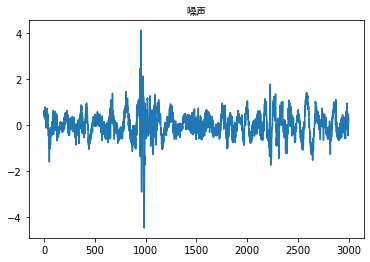

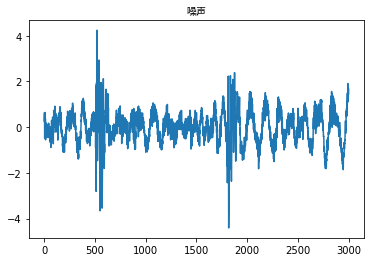

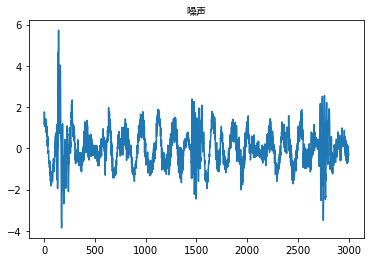

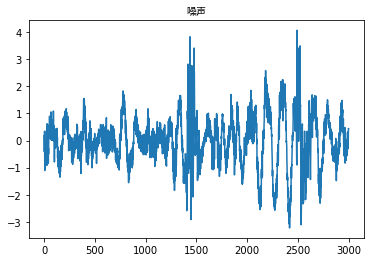

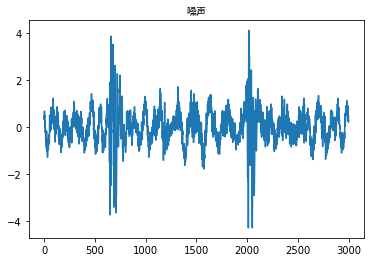

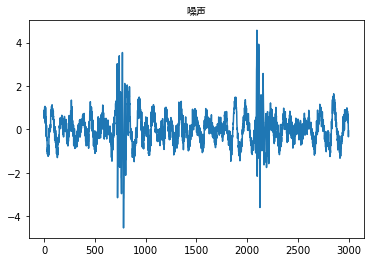

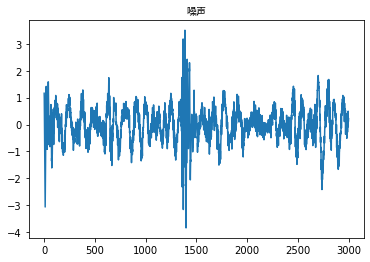

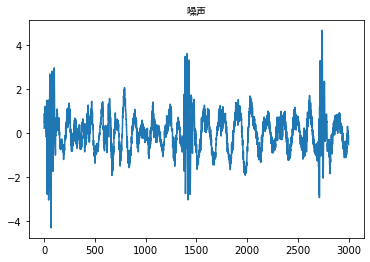

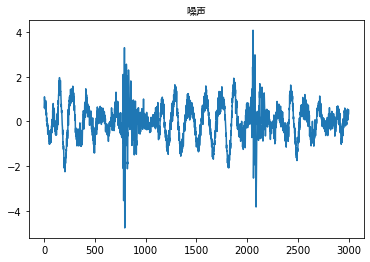

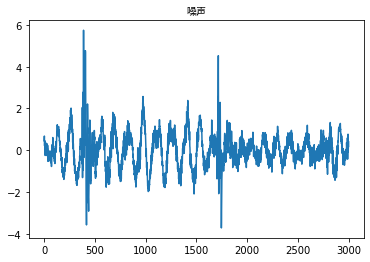

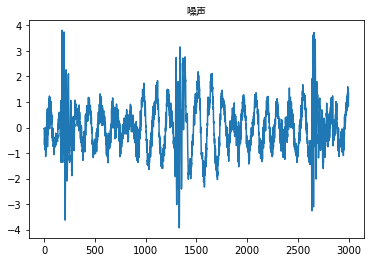

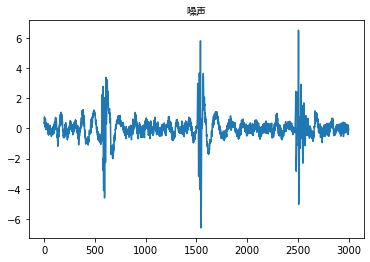

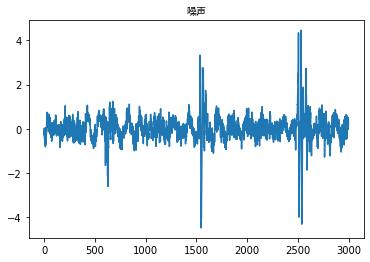

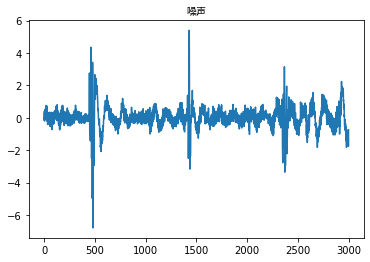

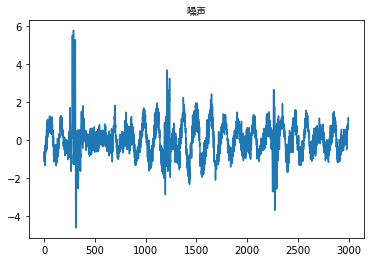

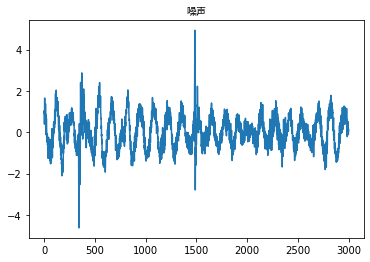

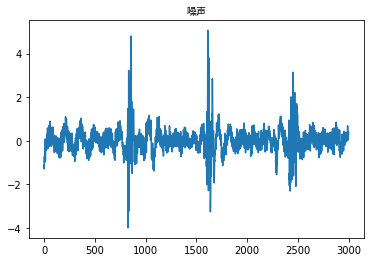

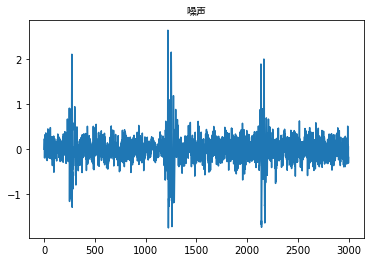

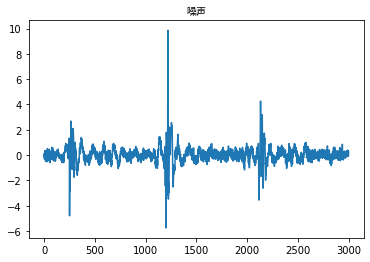

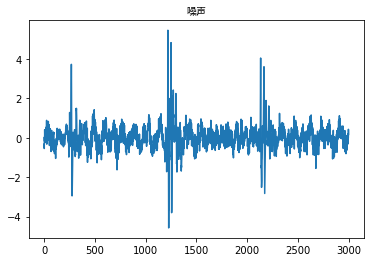

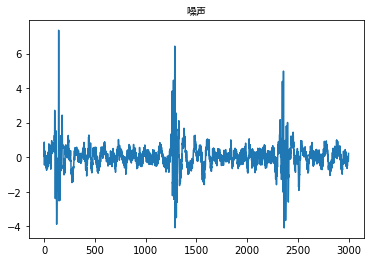

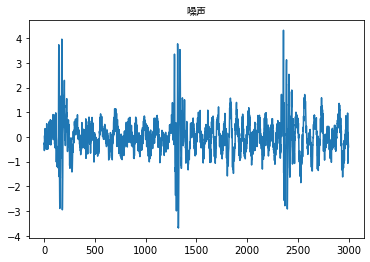

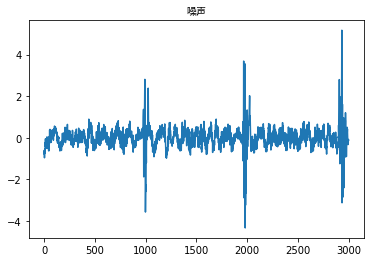

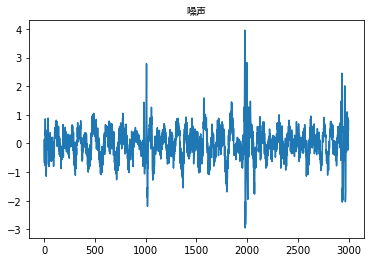

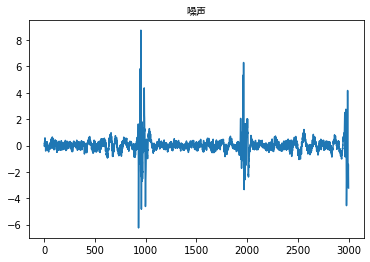

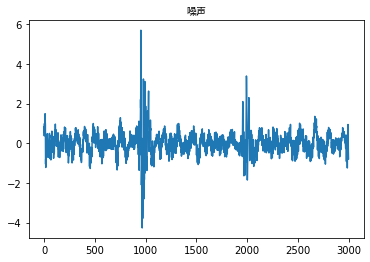

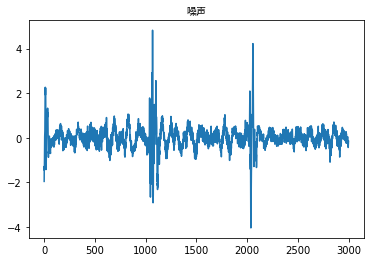

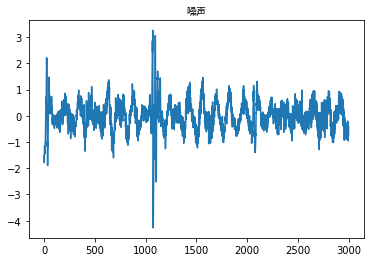

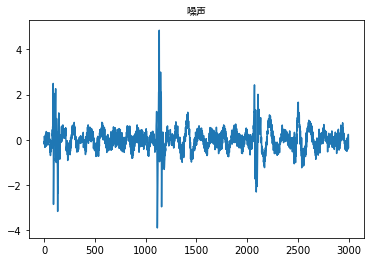

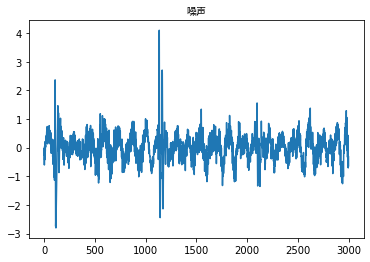

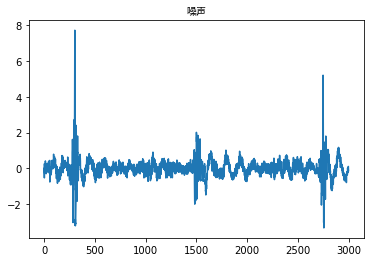

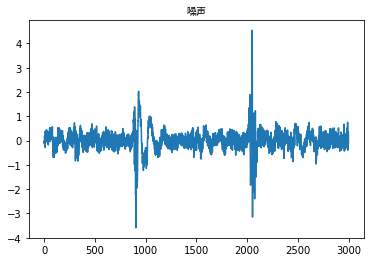

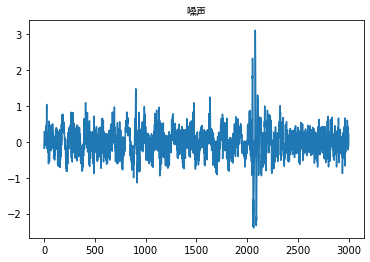

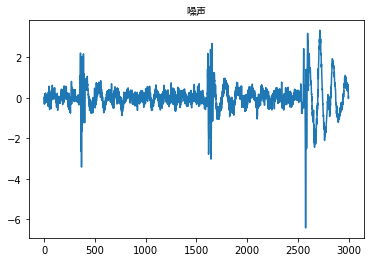

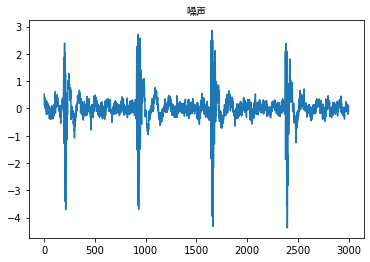

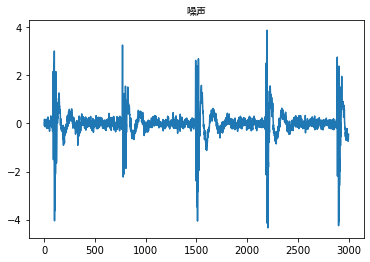

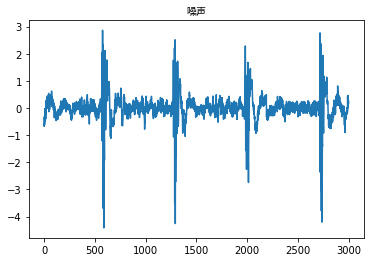

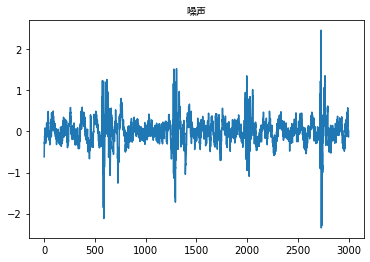

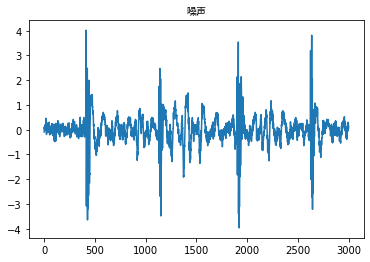

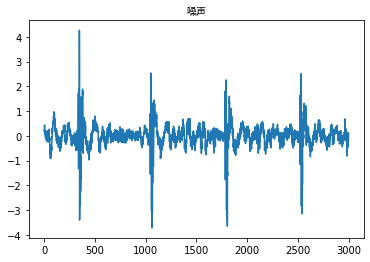

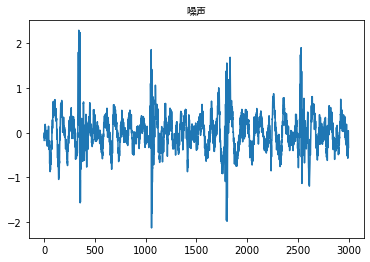

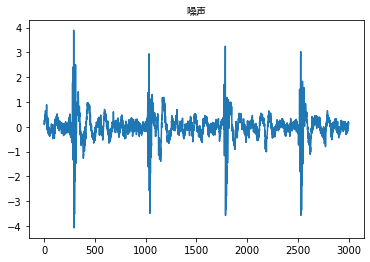

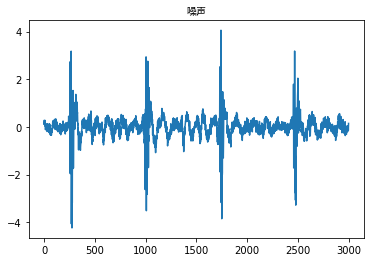

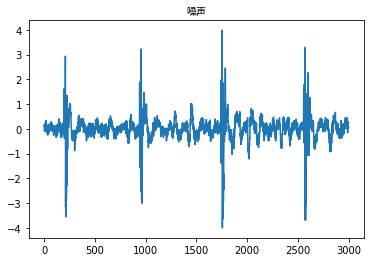

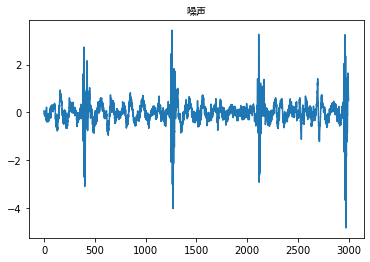

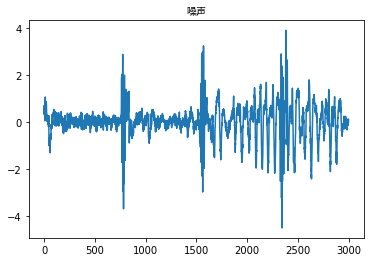

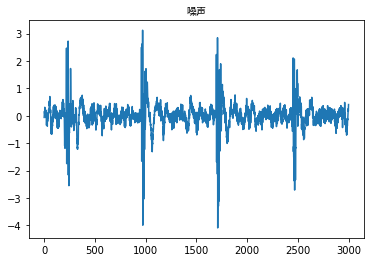

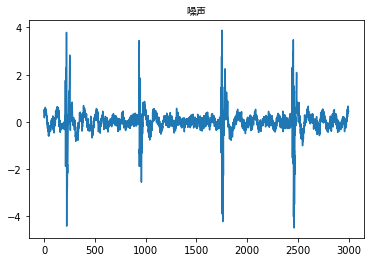

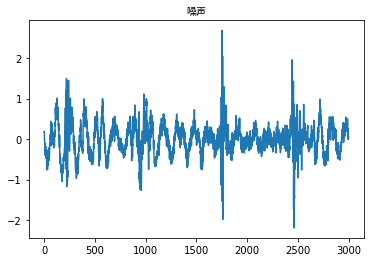

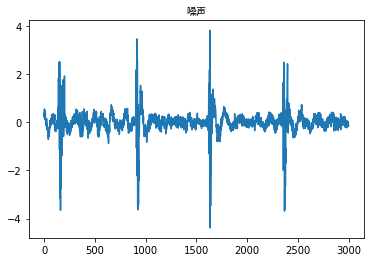

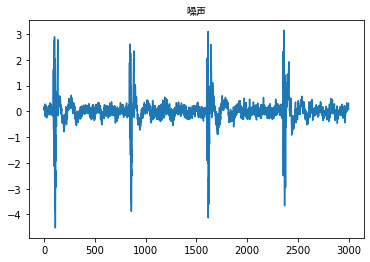

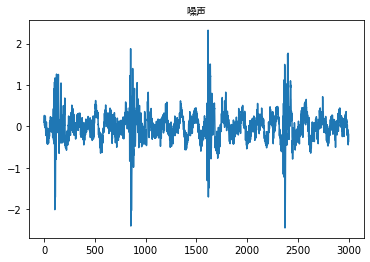

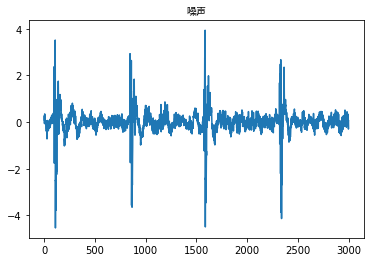

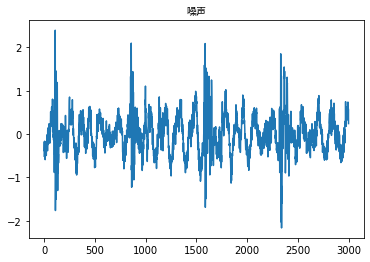

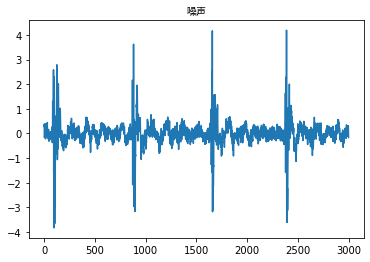

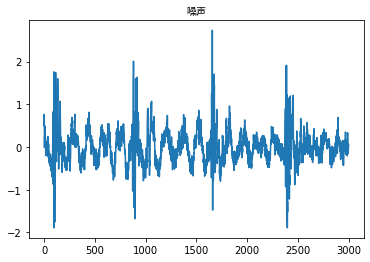

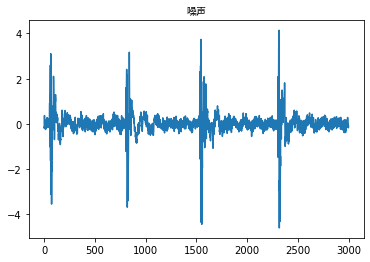

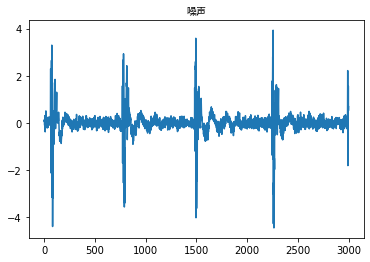

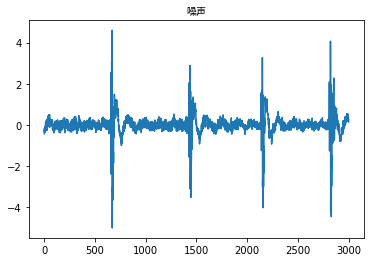

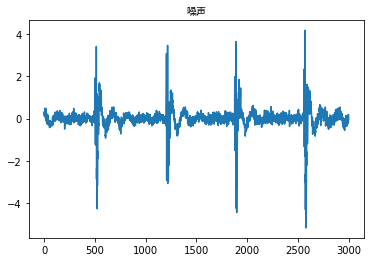

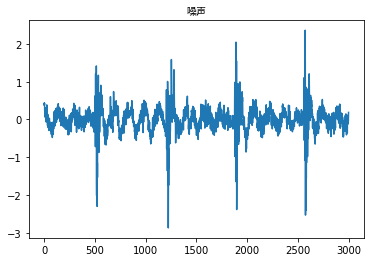

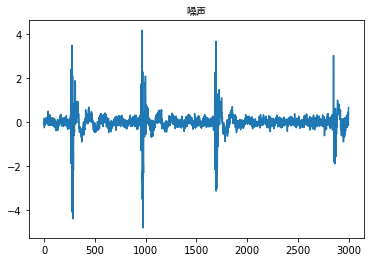

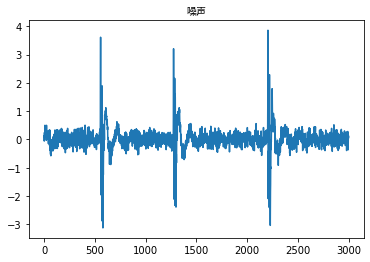

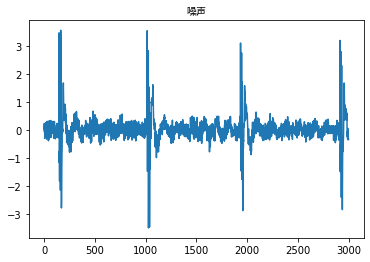

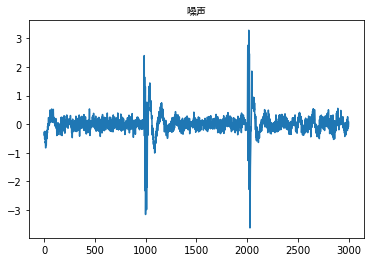

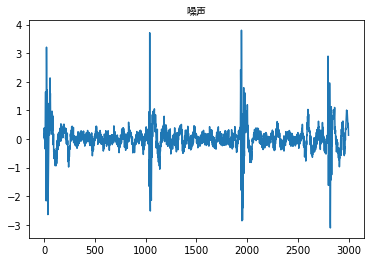

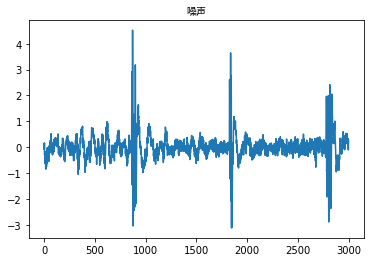

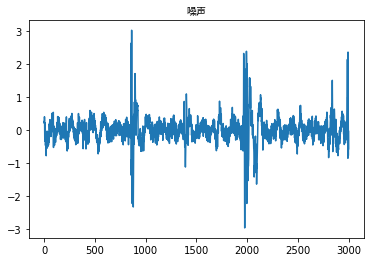

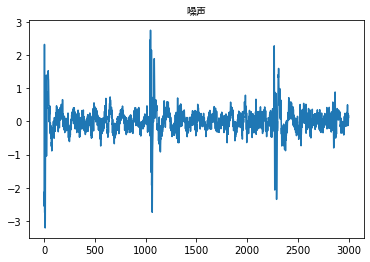

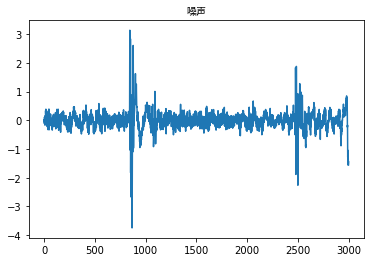

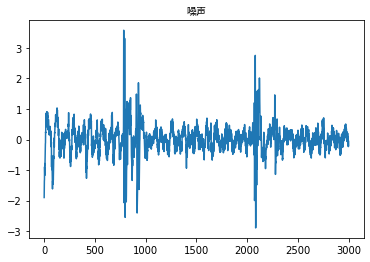

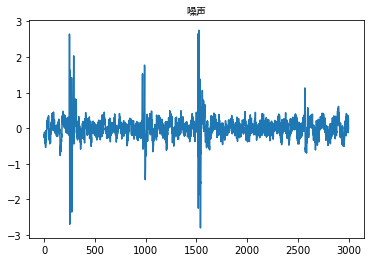

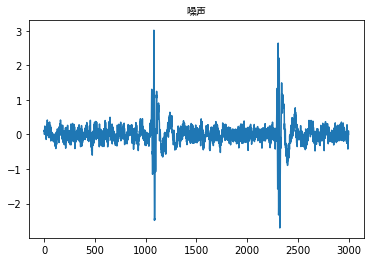

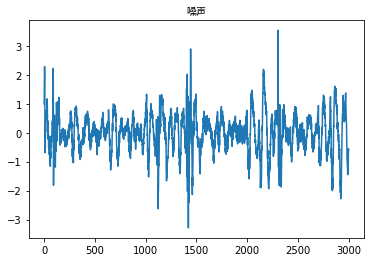

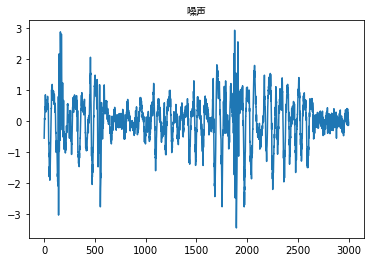

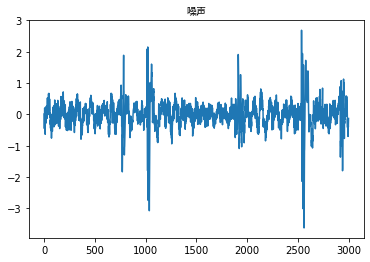

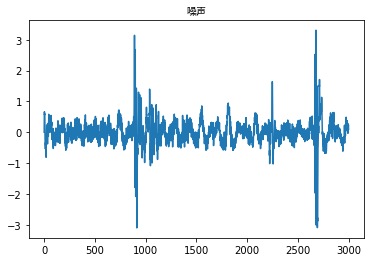

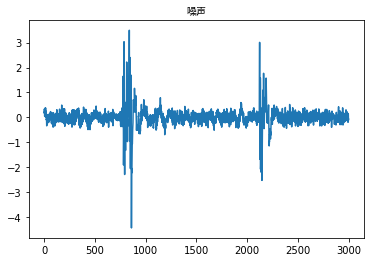

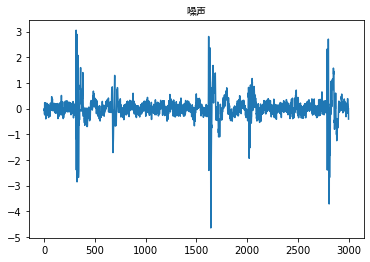

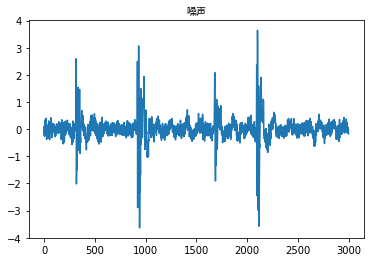

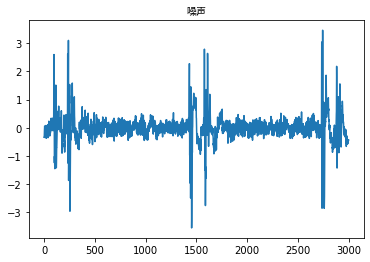

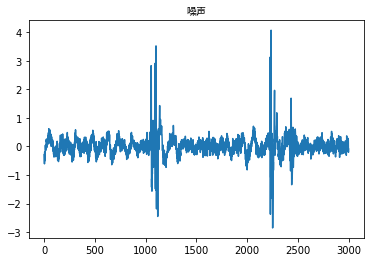

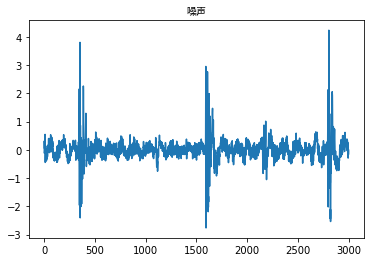

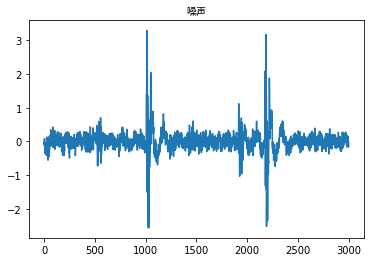

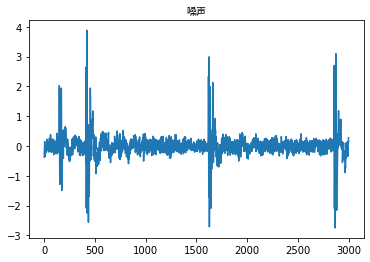

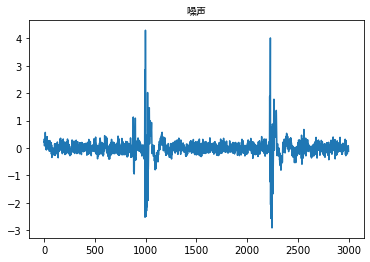

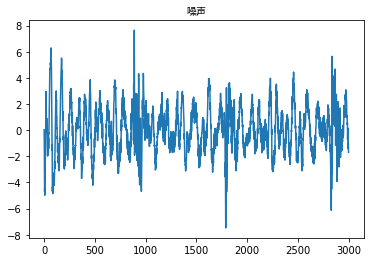

3986


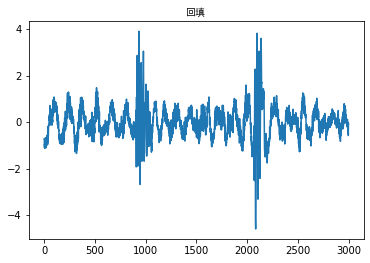

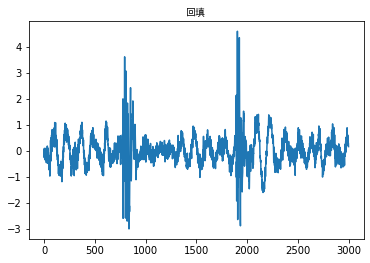

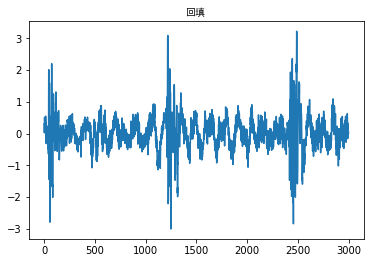

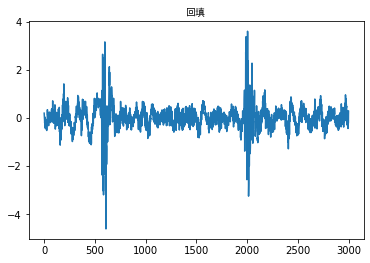

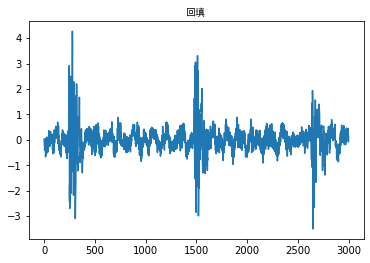

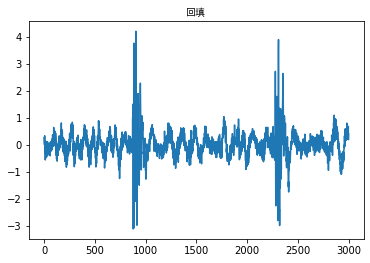

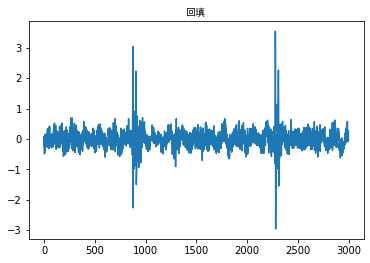

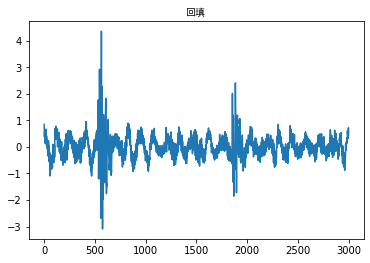

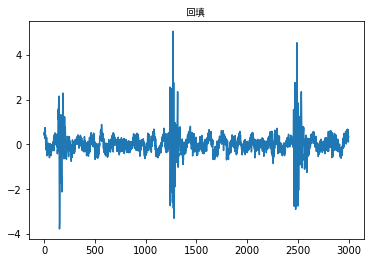

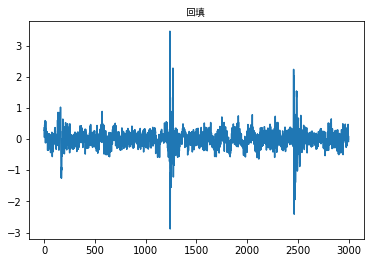

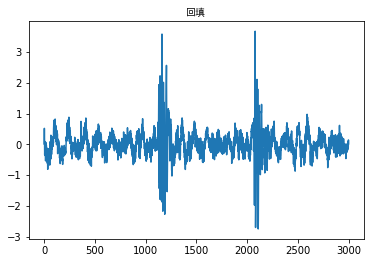

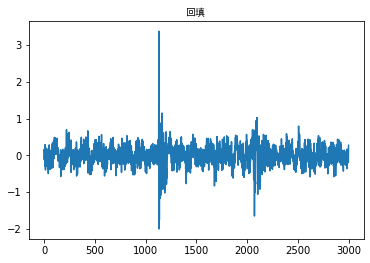

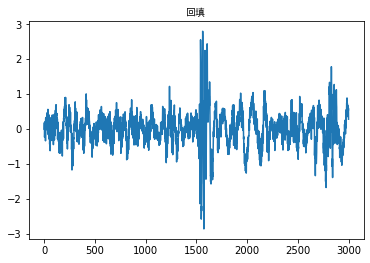

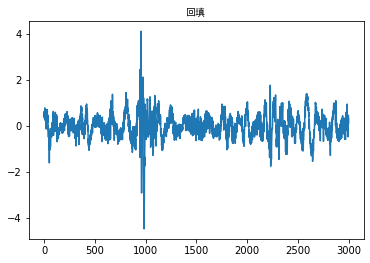

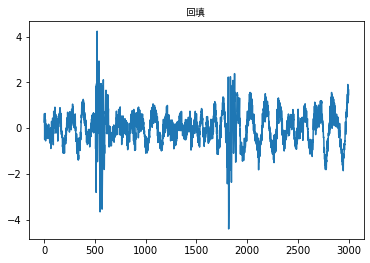

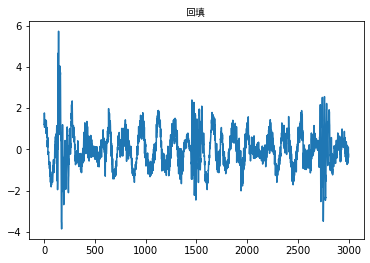

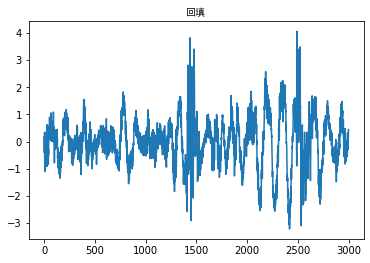

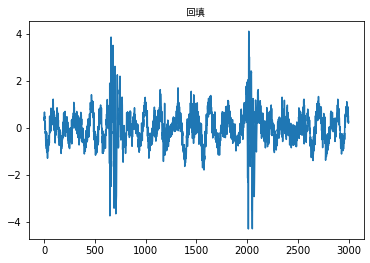

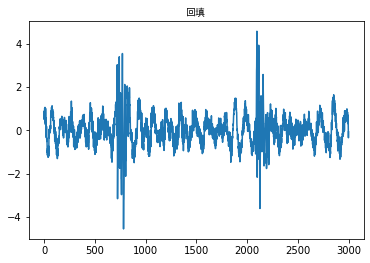

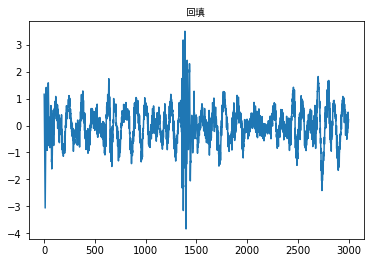

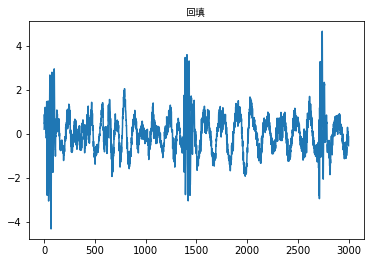

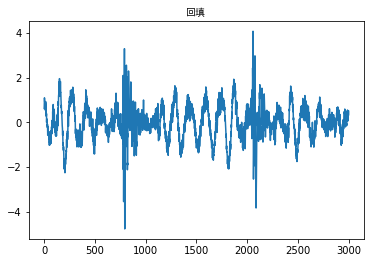

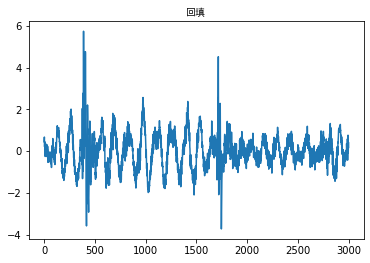

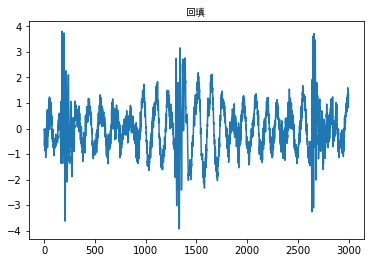

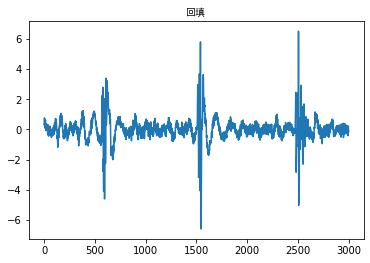

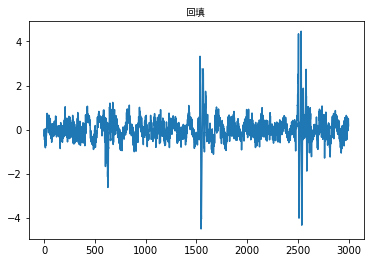

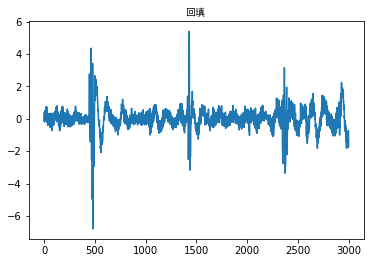

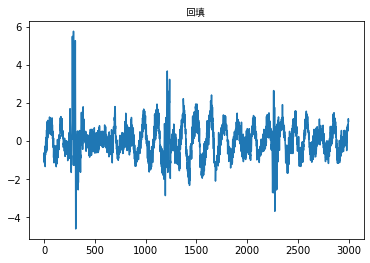

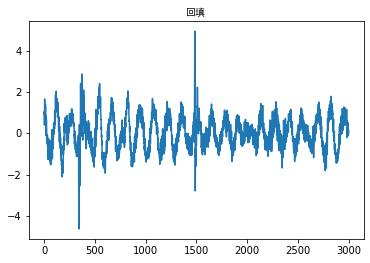

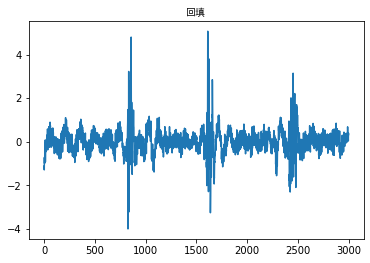

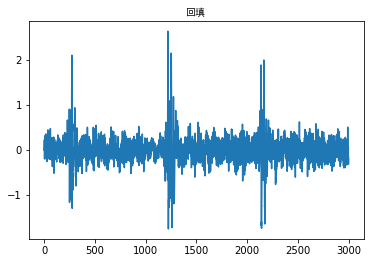

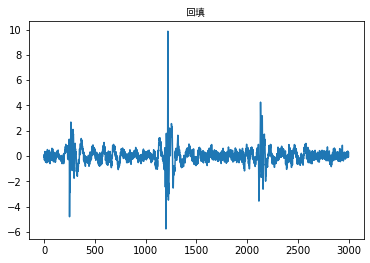

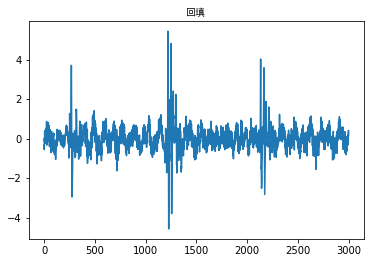

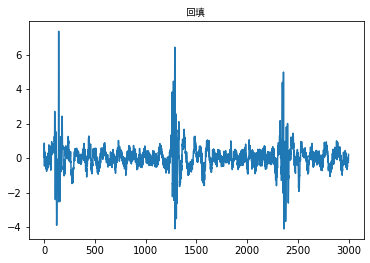

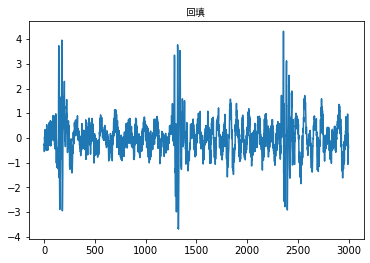

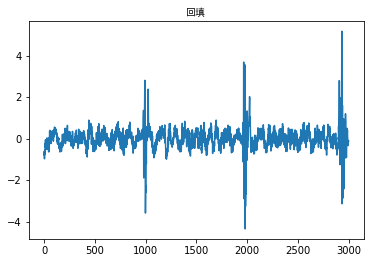

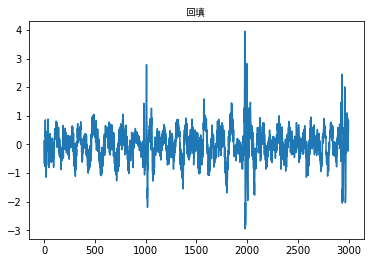

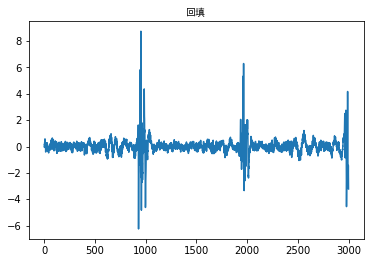

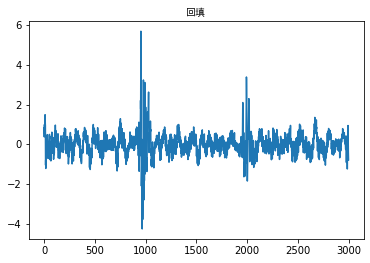

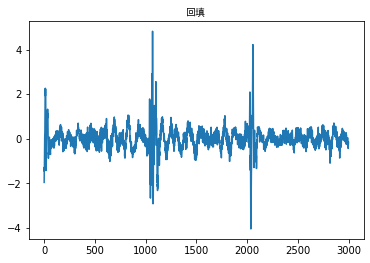

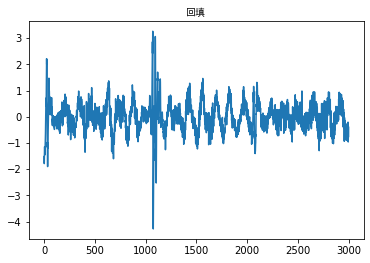

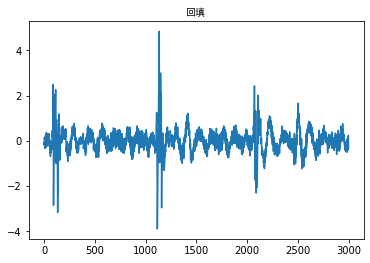

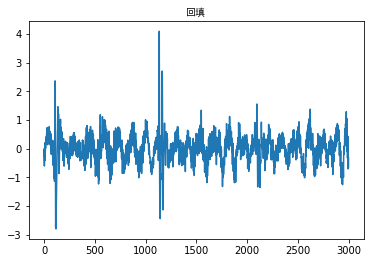

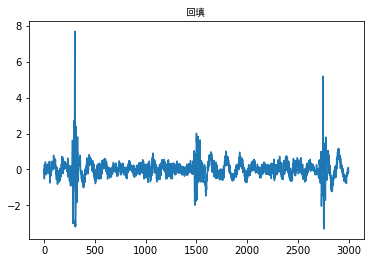

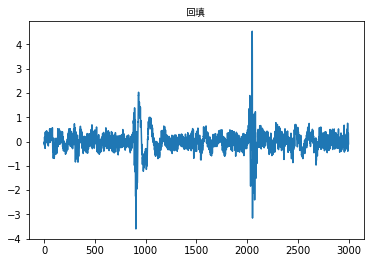

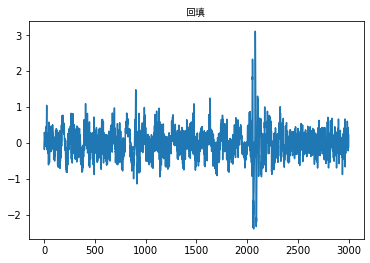

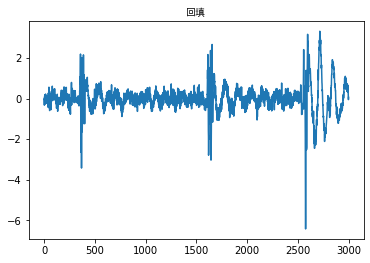

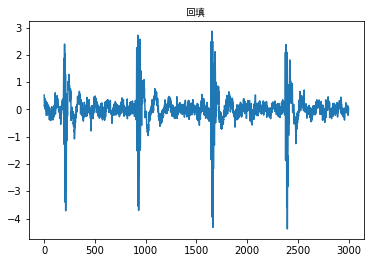

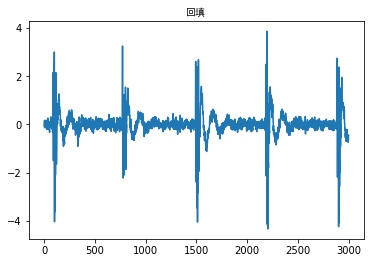

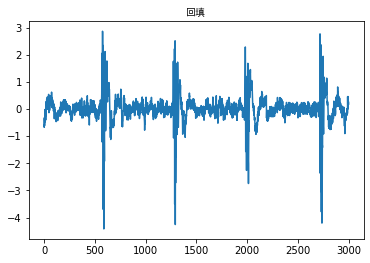

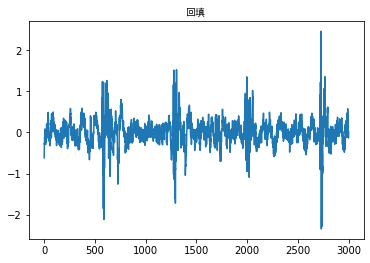

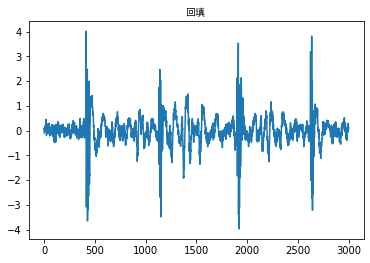

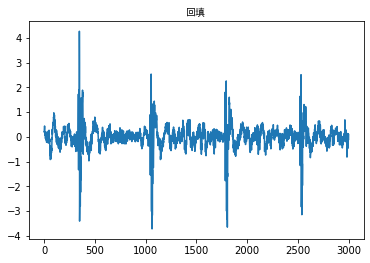

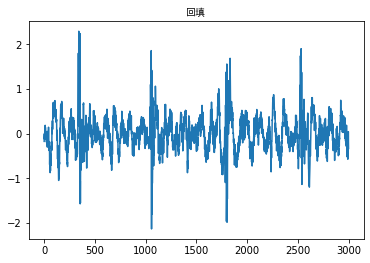

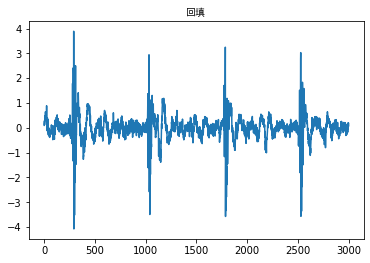

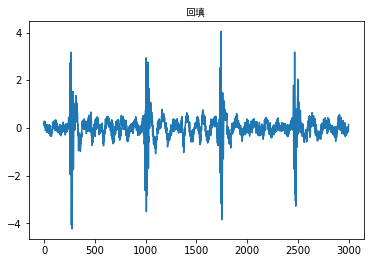

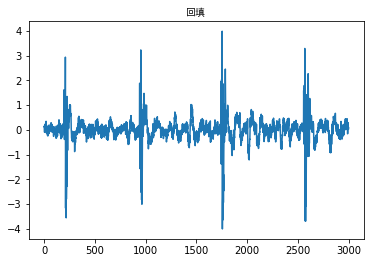

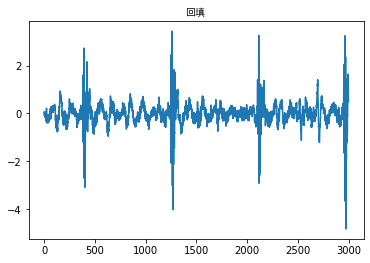

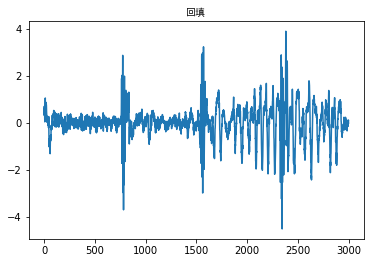

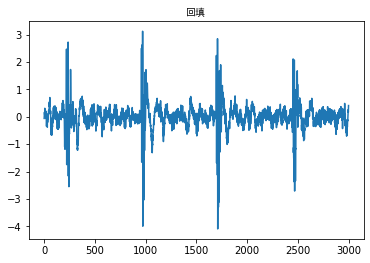

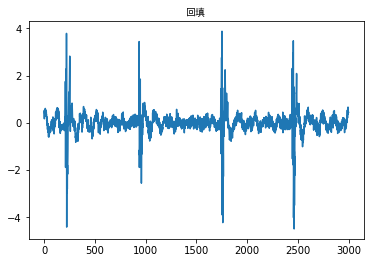

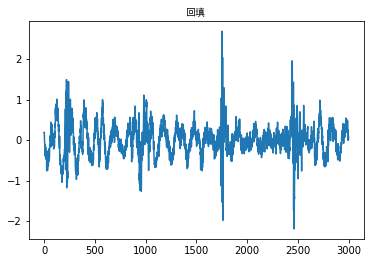

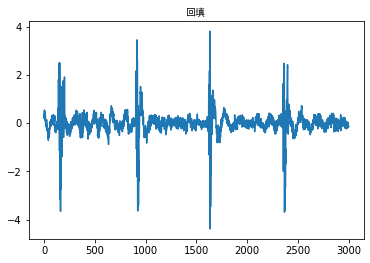

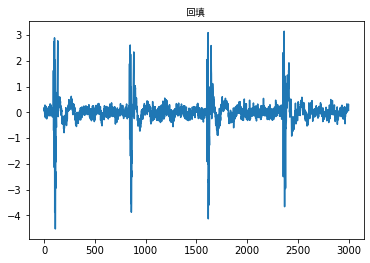

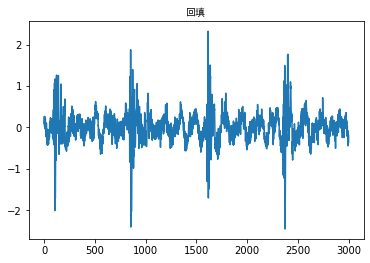

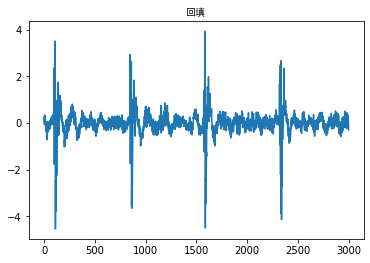

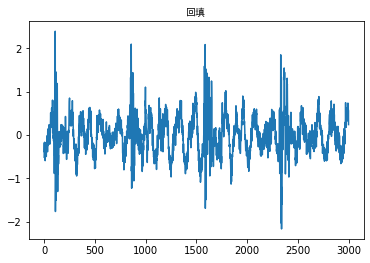

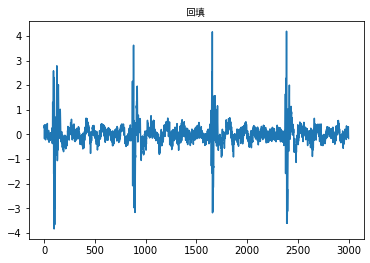

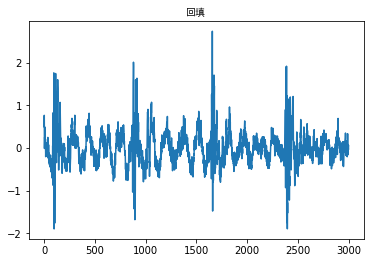

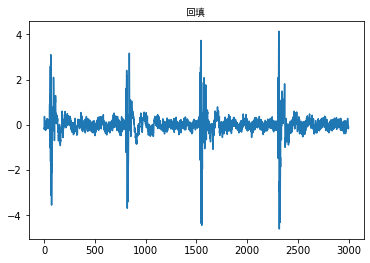

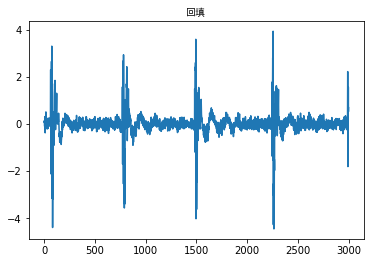

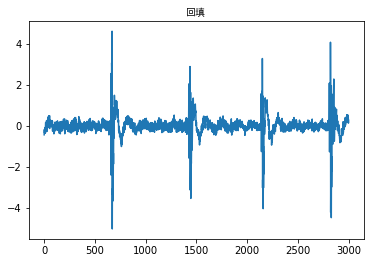

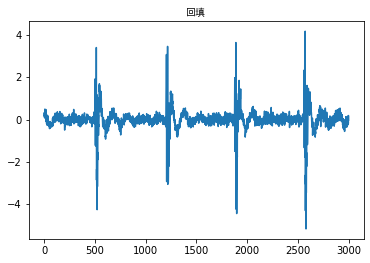

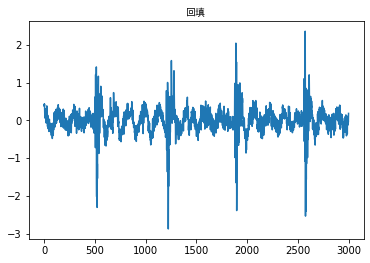

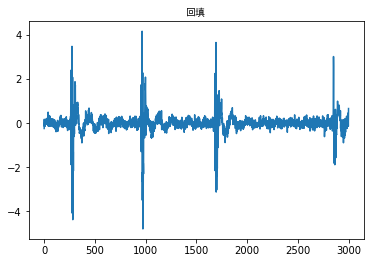

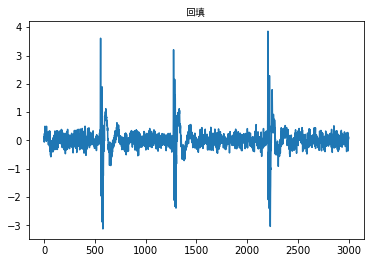

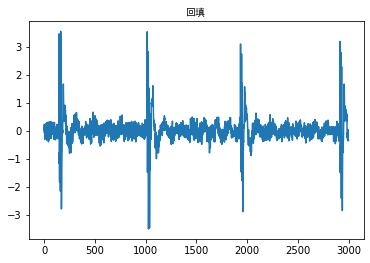

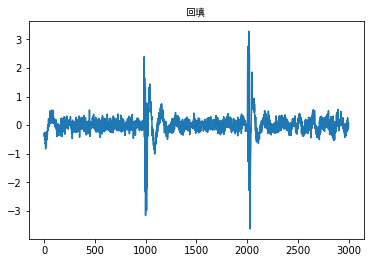

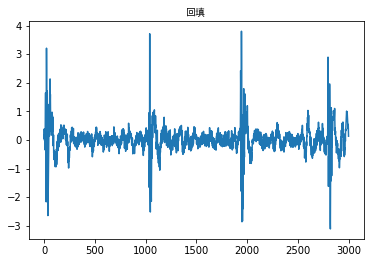

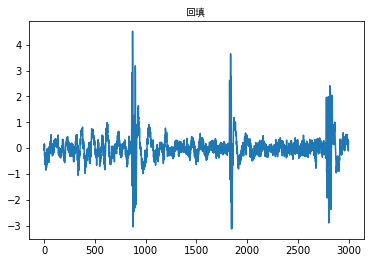

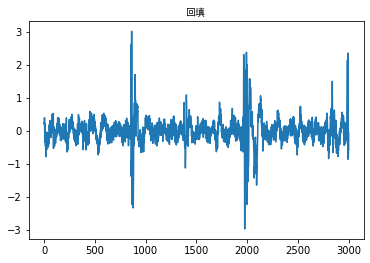

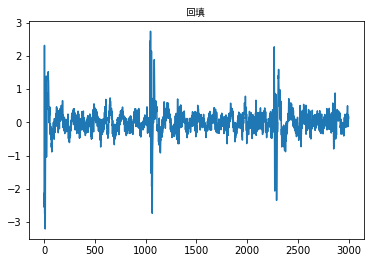

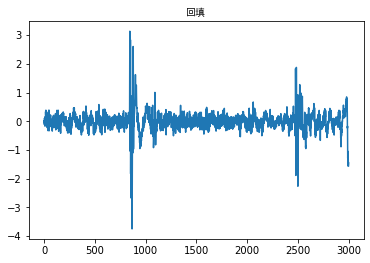

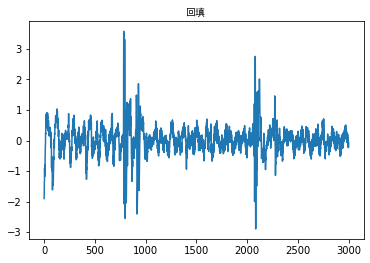

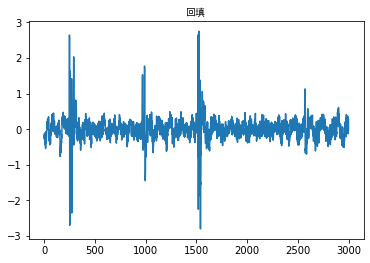

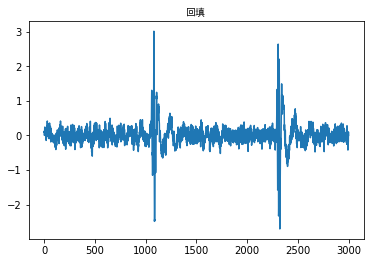

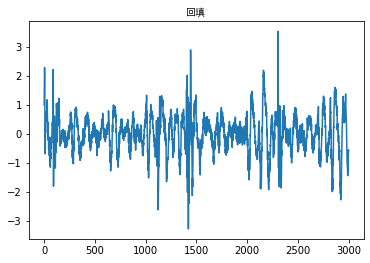

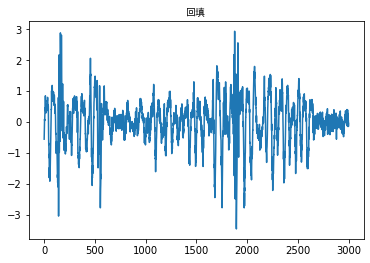

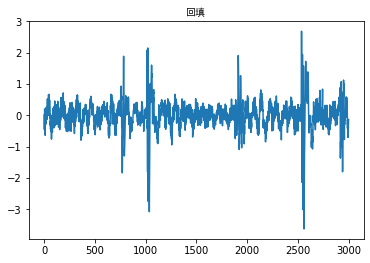

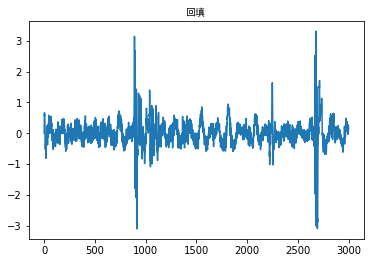

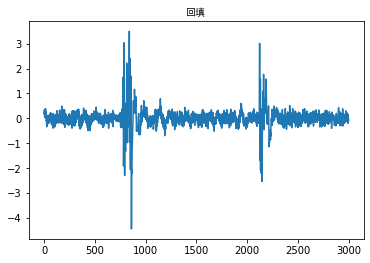

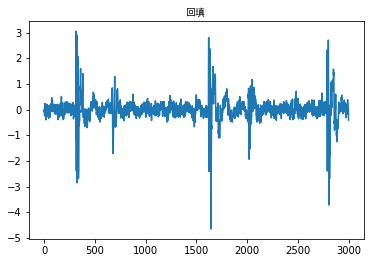

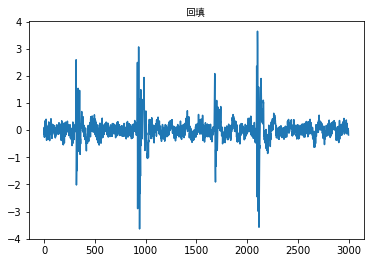

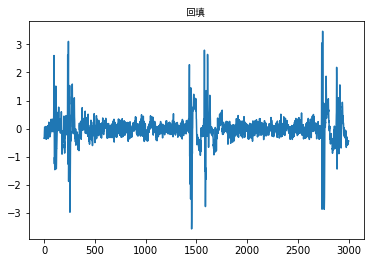

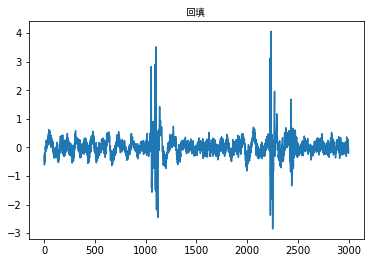

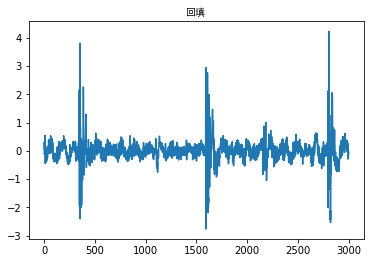

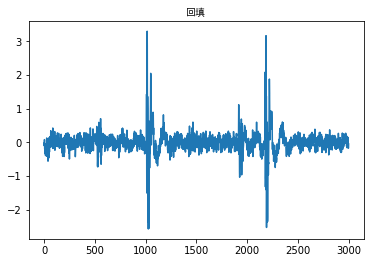

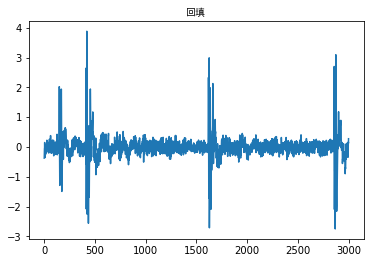

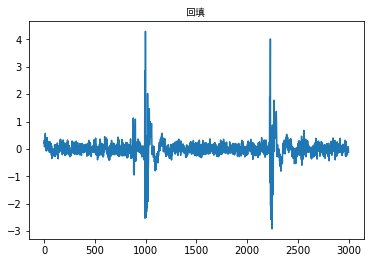

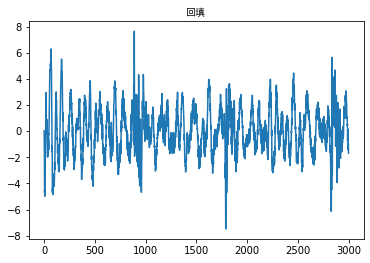

In [9]:
for i in range(0,n_event_test): # 行中
    print(Nf[i])
    for j in range(0,100):
        plt.clf() #清空画布上的所有内容
        plt.title(sigNames[i], fontproperties="SimHei") #     （黑体）
        plt.plot(test_data[j+1,:])
        plt.pause(0.01)
    plt.pause(1)

(11316,)
[3142, 7166, 11152, 11316]
[1 6]
[6 2]
[2 5]
[5]


(11316, 7)
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]
